#  627 PROJECT
## Group 23｜Nov 2024

In [1]:
import numpy as np
import pandas as pd


# Plot
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import plotly.graph_objs as go


# Import data
from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import time
import re

# Import xlrd ####
import warnings
warnings.filterwarnings("ignore")

# Random Number
import random

# Optimize
from skopt import gp_minimize
from functools import partial


# Let's set some print option.

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [2]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perception (Neural Networks)
from sklearn.neural_network import MLPRegressor

In [3]:
# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for feature selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

from itertools import product

In [4]:
spy = yf.download('SPY', "2005-11-01", "2024-11-01")

[*********************100%%**********************]  1 of 1 completed


###  <a id = "top">Table of Contents</a>  

# [Part 1: Strategies](#p1)
### <span style="color:green; font-weight:bold;">1.1 Momentum Strategy</span>
- <span style="font-weight:bold; color:orange">1.1.1 Simple Moving Average</span>
- <span style="font-weight:bold; color:orange">1.1.2 Exponential Moving Average</span>
### <span style="color:green; font-weight:bold;">1.2 Mean Reversion</span>
- <span style="font-weight:bold; color:orange">1.2.1 Bollinger Bands</span>
- <span style="font-weight:bold; color:orange">1.2.2 MACD</span>
### <span style="color:green; font-weight:bold;">1.3 Combination Strategy</span>
- <span style="font-weight:bold; color:orange">1.3.1 Simple Moving Average + MACD </span>
### <span style="color:green; font-weight:bold;">1.4 Machine Learning</span>

# [Part 2: Backtesting](#p7)

# [Part 3: Executive Summary](#p9)

# [Part 4: Self-Critique](#p10)

# [Part 5: Contribution Statement](#p11)

# Descriptive Statistics of the Data

In [5]:
# to obtain simple descriptive statistics of the data 
spy.describe()

Open         High          Low        Close    Adj Close  \
count  4782.000000  4782.000000  4782.000000  4782.000000  4782.000000   
mean    237.124362   238.455663   235.672154   237.154235   211.525542   
std     123.766541   124.358957   123.114063   123.787167   131.284476   
min      67.949997    70.000000    67.099998    68.110001    50.701164   
25%     134.235004   135.112499   133.389999   134.360001   101.466934   
50%     203.295006   204.264999   202.154999   203.240005   172.652527   
75%     303.582497   306.345009   300.702492   303.479996   283.043076   
max     585.909973   586.119995   582.580017   584.590027   584.590027   

             Volume  
count  4.782000e+03  
mean   1.290601e+08  
std    9.233783e+07  
min    1.527000e+07  
25%    6.847260e+07  
50%    9.860150e+07  
75%    1.592438e+08  
max    8.710263e+08

In [6]:
# to check if missing data exists
spy.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

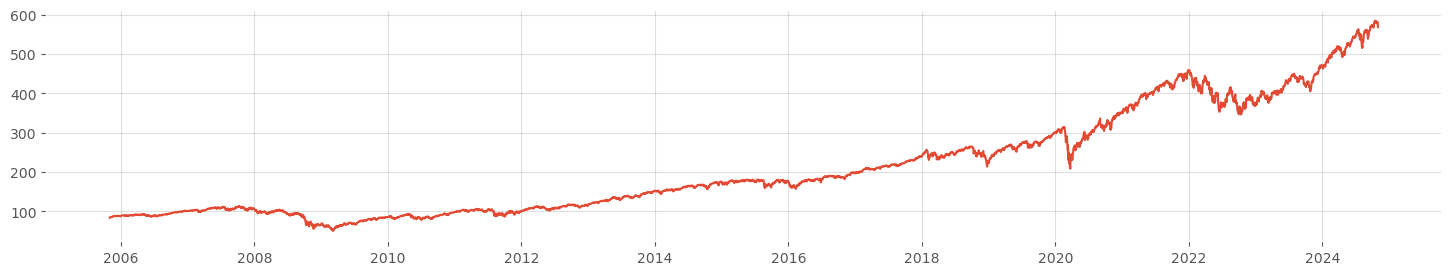

In [7]:
# to visualise price trend 
plt.figure(figsize=[18,3])
plt.plot(spy["Adj Close"])
plt.show()

In [8]:
def stk_cumulative_ret(stk):
    stk_df = stk.copy()
    stk_df["daily_ret"] = np.log(stk_df["Adj Close"] / stk_df["Adj Close"].shift(1)) # log returns
    stk_df["position"] = 1 
    stk_df["strategy_ret"] = stk_df["position"].shift(1) * stk_df["daily_ret"] # assume trade on next day
    stk_df["cum_ret"] = stk_df["strategy_ret"].cumsum().apply(np.exp) # normal returns 
    return stk_df 

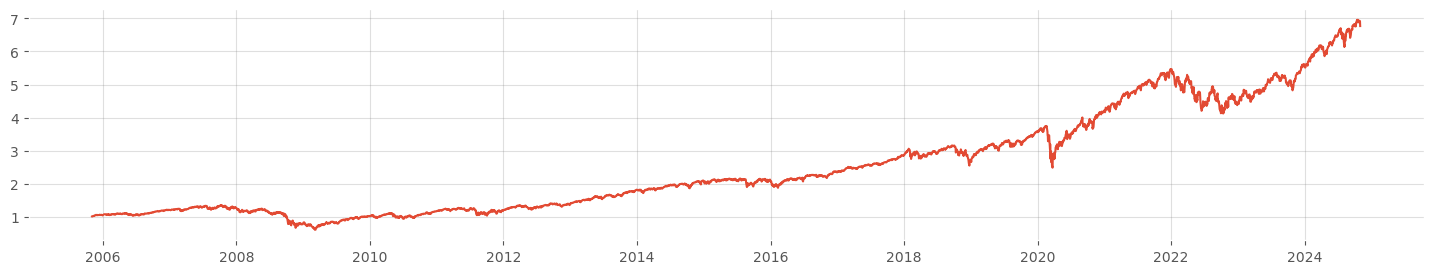

In [9]:
no_strat_base_ret = stk_cumulative_ret(spy[["Adj Close"]])[["cum_ret"]]
plt.figure(figsize=[18,3])
plt.plot(no_strat_base_ret)
plt.show()

# <a id = "p1">1 </a> <font color = "green"> Part 1 </font> [back to table of contents](#top)

# <a id = "p2">1.1 </a> <font color = "green"> Simple and Exponential Moving Average Strategy </font> [back to table of contents](#top)

In [10]:
def MA_strategy(stk, short_MA, long_MA, MA_method="SMA", long_only=True):
    
    stk_df = stk.copy()

    if MA_method == "SMA":
        stk_df[f"{short_MA}_{MA_method}"] = stk_df["Adj Close"].rolling(short_MA, min_periods=1).mean()
        stk_df[f"{long_MA}_{MA_method}"] = stk_df["Adj Close"].rolling(long_MA, min_periods=1).mean()
    elif MA_method == "EMA":
        stk_df[f"{short_MA}_{MA_method}"] = stk_df["Adj Close"].ewm(span=short_MA, adjust=False).mean()
        stk_df[f"{long_MA}_{MA_method}"] = stk_df["Adj Close"].ewm(span=long_MA, adjust=False).mean()

    if long_only:
        stk_df["position"] = np.where(
            stk_df[f"{short_MA}_{MA_method}"] >= stk_df[f"{long_MA}_{MA_method}"], 1, 0
        )
    else:
        stk_df["position"] = np.where(
            stk_df[f"{short_MA}_{MA_method}"] > stk_df[f"{long_MA}_{MA_method}"], 1,
            np.where(stk_df[f"{short_MA}_{MA_method}"] < stk_df[f"{long_MA}_{MA_method}"], -1, 0)
        )
    
    return stk_df

In [11]:
def stk_cumulative_ret(stk_df):
    stk_df["Daily_Return"] = stk_df["Adj Close"].pct_change()
    stk_df["Strategy_Return"] = stk_df["position"].shift(1) * stk_df["Daily_Return"]
    stk_df["cum_ret"] = (1 + stk_df["Strategy_Return"]).cumprod()
    return stk_df

In [12]:
def determine_MA_valid(stk, short_MA, long_MA, MA_method="SMA", long_only=True):
    if short_MA >= long_MA:
        return float('inf')
    try:
        stk_df = MA_strategy(stk, short_MA, long_MA, MA_method, long_only)
        stk_df = stk_cumulative_ret(stk_df)
        return -stk_df['cum_ret'].iloc[-1]  # Negative cumulative return for minimization
    except Exception as e:
        print(f"Error with short={short_MA}, long={long_MA}: {e}")
        return float('inf')

In [13]:
def MA_parameter_tuning(stk, short_bounds, long_bounds, MA_method="SMA", long_only=True):
    short_range = range(short_bounds[0], short_bounds[1] + 1)
    long_range = range(long_bounds[0], long_bounds[1] + 1)
    best_params = None
    best_cumulative_return = float('-inf')
    
    for short_MA, long_MA in product(short_range, long_range):
        if short_MA < long_MA:
            try:
                result = determine_MA_valid(stk, short_MA, long_MA, MA_method, long_only)
                cumulative_return = -result  # Flip the sign to positive
                if cumulative_return > best_cumulative_return:
                    best_cumulative_return = cumulative_return
                    best_params = (short_MA, long_MA)
            except Exception as e:
                print(f"Error for short={short_MA}, long={long_MA}: {e}")
                continue

    return best_params, best_cumulative_return

In [14]:
short_bounds = (5, 30) 
long_bounds = (20, 200) 

SMA_long_parameters, SMA_long_cumulative_return = MA_parameter_tuning(spy, 
                                                                      short_bounds, 
                                                                      long_bounds, 
                                                                      MA_method="SMA", 
                                                                      long_only=True)

print("")
print("SMA Long Only Strategy:")
print(f"Short={SMA_long_parameters[0]}, Long={SMA_long_parameters[1]}")
print(f"Cumulative Return: {SMA_long_cumulative_return}")

short_bounds = (5, 30) 
long_bounds = (20, 200)

EMA_long_parameters, EMA_long_cumulative_return = MA_parameter_tuning(spy, 
                                                                      short_bounds, 
                                                                      long_bounds, 
                                                                      MA_method="EMA", 
                                                                      long_only=True)

print("")
print("EMA Long Only Strategy:")
print(f"Short={EMA_long_parameters[0]}, Long={EMA_long_parameters[1]}")
print(f"Cumulative Return: {EMA_long_cumulative_return}")

short_bounds = (20, 100) 
long_bounds = (50, 300)

SMA_longshort_parameters, SMA_longshort_cumulative_return = MA_parameter_tuning(spy, 
                                                                                short_bounds, 
                                                                                long_bounds, 
                                                                                MA_method="SMA", 
                                                                                long_only=False)

print("")
print("SMA Long Short Strategy:")
print(f"Short={SMA_longshort_parameters[0]}, Long={SMA_longshort_parameters[1]}")
print(f"Cumulative Return: {SMA_longshort_cumulative_return}")

short_bounds = (20, 100) 
long_bounds = (50, 300)

EMA_longshort_parameters, EMA_longshort_cumulative_return = MA_parameter_tuning(spy, 
                                                                                short_bounds, 
                                                                                long_bounds, 
                                                                                MA_method="EMA", 
                                                                                long_only=False)

print("")
print("EMA Long Short Strategy:")
print(f"Short={EMA_longshort_parameters[0]}, Long={EMA_longshort_parameters[1]}")
print(f"Cumulative Return: {EMA_longshort_cumulative_return}")


SMA Long Only Strategy:
Short=30, Long=178
Cumulative Return: 6.418901376455407

EMA Long Only Strategy:
Short=29, Long=62
Cumulative Return: 6.142348951245012

SMA Long Short Strategy:
Short=46, Long=161
Cumulative Return: 4.4203129647637605

EMA Long Short Strategy:
Short=97, Long=277
Cumulative Return: 4.572010214833368


In [15]:
def strategy_ret_summary(df, initial_capital, df_baseline, long_only=True):

    ending_capital = initial_capital * df["cum_ret"].iloc[-1]
    print(f"Ending capital is ${ending_capital:,.2f}")

    annualized_ret = np.mean(df["Strategy_Return"]) * 252  
    annualized_vol = np.std(df["Strategy_Return"]) * np.sqrt(252) 
    sharpe_ratio = annualized_ret / annualized_vol
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    days = (df.index[-1] - df.index[0]).days
    cagr = (df["cum_ret"].iloc[-1]) ** (365 / days) - 1
    print(f"Compound Annual Growth Rate (CAGR): {cagr:.4%}")

    df["Max_performance"] = df["cum_ret"].cummax()
    df["Drawdown"] = (df["cum_ret"] - df["Max_performance"]) / df["Max_performance"]
    drawdown_periods = df["Drawdown"] < 0
    drawdown_groups = (drawdown_periods != drawdown_periods.shift()).cumsum() * drawdown_periods

    drawdown_stats = []
    for group_id, group_data in df.groupby(drawdown_groups):
        if group_id == 0:  
            continue
        start_date = group_data.index[0]
        end_date = group_data.index[-1]
        calendar_days = (end_date - start_date).days
        business_days = group_data.shape[0]
        max_drawdown = group_data["Drawdown"].min() * 100 
        drawdown_stats.append({
            "Start Date": start_date,
            "End Date": end_date,
            "Max Drawdown (%)": max_drawdown,
            "Calendar Days": calendar_days,
        })
    drawdown_df = pd.DataFrame(drawdown_stats)

    if not drawdown_df.empty:
        max_drawdown_row = drawdown_df.loc[drawdown_df["Max Drawdown (%)"].idxmin()]
        print(f"Maximum Drawdown: {max_drawdown_row['Max Drawdown (%)']:.4%}")
        print(f"Drawdown Duration: {max_drawdown_row['Calendar Days']} calendar days")
    else:
        print("No drawdown detected.")

    plt.figure(figsize=[18, 10])
    plt.plot(df["cum_ret"], label='Strategy', linewidth=2)
    plt.plot(df_baseline, label='Baseline', linewidth=2, linestyle='--')

    if long_only:
        entry_points = df[df["position"].diff() == 1].index  
        exit_points = df[df["position"].diff() == -1].index 
        plt.scatter(entry_points, df["cum_ret"].loc[entry_points] - 0.1, 
                    label="Long Entry Points", color="green", marker="^", s=100)
        plt.scatter(exit_points, df["cum_ret"].loc[exit_points] + 0.1, 
                    label="Long Exit Points", color="red", marker="v", s=100)
    else:
        long_entry_points = df[df["position"].diff() == 1].index 
        long_exit_points = df[df["position"].diff() == -1].index 
        short_entry_points = df[df["position"].diff() == -2].index  
        short_exit_points = df[df["position"].diff() == 2].index  
        plt.scatter(long_entry_points, df["cum_ret"].loc[long_entry_points] - 0.1, 
                    label="Long Entry", color="green", marker="^", s=100)
        plt.scatter(long_exit_points, df["cum_ret"].loc[long_exit_points] + 0.1, 
                    label="Long Exit", color="red", marker="v", s=100)
        plt.scatter(short_entry_points, df["cum_ret"].loc[short_entry_points] + 0.1, 
                    label="Short Entry", color="blue", marker="^", s=100)
        plt.scatter(short_exit_points, df["cum_ret"].loc[short_exit_points] - 0.1, 
                    label="Short Exit", color="orange", marker="v", s=100)

    plt.title("Strategy's Cumulative Returns vs Baseline Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()

    plt.figure(figsize=(18, 5))
    plt.plot(df["cum_ret"], label="Cumulative Return", linewidth=2, alpha=0.8)
    plt.plot(df["Max_performance"], label="Max Performance", linewidth=2, alpha=0.8)
    plt.fill_between(df.index, df["cum_ret"], df["Max_performance"],
                     where=df["cum_ret"] < df["Max_performance"],
                     color="red", alpha=0.3, label="Drawdown")
    plt.title("Maximum Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# <a id = "p3">1.2 </a> <font color = "green"> MACD Strategy </font> [back to table of contents](#top)

In [16]:
def MACD_strategy(df, short_EMA, long_EMA, signal_EMA, long_only=True):
    stk_df = df.copy()
    stk_df["short_EMA"] = stk_df["Adj Close"].ewm(span=short_EMA, adjust=False).mean()
    stk_df["long_EMA"] = stk_df["Adj Close"].ewm(span=long_EMA, adjust=False).mean()

    stk_df["MACD"] = stk_df["short_EMA"] - stk_df["long_EMA"]
    stk_df["MACD_Signal"] = stk_df["MACD"].ewm(span=signal_EMA, adjust=False).mean()

    if long_only:
        stk_df["position"] = np.where(stk_df["MACD"] > stk_df["MACD_Signal"], 1, 0)
    else:
        stk_df["position"] = np.where(stk_df["MACD"] > stk_df["MACD_Signal"], 1,
                                      np.where(stk_df["MACD"] < stk_df["MACD_Signal"], -1, 0))

    return stk_df

In [17]:
def optimize_MACD_parameters(stk_df, short_range, long_range, signal_range, long_only=True):
    best_params = None
    best_cumulative_return = float('-inf')

    for short in range(short_range[0], short_range[1] + 1):
        for long in range(long_range[0], long_range[1] + 1):
            if short >= long:  
                continue
            for signal in range(signal_range[0], signal_range[1] + 1):
                try:
                    temp_df = MACD_strategy(stk_df, short, long, signal, long_only)
                    temp_df = stk_cumulative_ret(temp_df)
                    cumulative_return = temp_df["cum_ret"].iloc[-1]
                    if cumulative_return > best_cumulative_return:
                        best_cumulative_return = cumulative_return
                        best_params = (short, long, signal)
                except Exception as e:
                    print(f"Error for short={short}, long={long}, signal={signal}: {e}")
                    continue

    print(f"MACD Parameters: {best_params}")
    print(f"Cumulative Return: {best_cumulative_return:.2f}")
    return best_params, best_cumulative_return

# <a id = "p4">1.2 </a> <font color = "green"> Bollinger Band Strategy </font> [back to table of contents](#top)

In [18]:
def Bollinger_strategy(df, period, multiplier, long_only=True):
    
    stk_df = df.copy()

    stk_df[f"SMA_{period}"] = stk_df["Adj Close"].rolling(period).mean()
    stk_df["upper_band"] = stk_df[f"SMA_{period}"] + multiplier * stk_df["Adj Close"].rolling(period).std()
    stk_df["lower_band"] = stk_df[f"SMA_{period}"] - multiplier * stk_df["Adj Close"].rolling(period).std()

    # Determine positions
    if long_only:
        stk_df["position"] = np.where(stk_df["Adj Close"] < stk_df["lower_band"], 1, 0)
    else:
        stk_df["position"] = np.where(stk_df["Adj Close"] > stk_df["upper_band"], -1,
                                      np.where(stk_df["Adj Close"] < stk_df["lower_band"], 1, 0))

    return stk_df

In [19]:
def optimize_Bollinger_parameters(stk_df, period_range, multiplier_range, long_only=True):
    best_params = None
    best_cumulative_return = float('-inf')

    for period in range(period_range[0], period_range[1] + 1):
        for multiplier in np.arange(multiplier_range[0], multiplier_range[1] + 0.1, 0.1):
            try:
                temp_df = Bollinger_strategy(stk_df, period, multiplier, long_only)
                temp_df = stk_cumulative_ret(temp_df)
                cumulative_return = temp_df["cum_ret"].iloc[-1]
                if cumulative_return > best_cumulative_return:
                    best_cumulative_return = cumulative_return
                    best_params = (period, multiplier)
            except Exception as e:
                print(f"Error for period={period}, multiplier={multiplier}: {e}")
                continue

    print(f"Bollinger Parameter: {best_params}")
    print(f"Cumulative Return: {best_cumulative_return:.2f}")
    return best_params, best_cumulative_return

# <a id = "p5">1.3 </a> <font color = "green"> Combination Strategy (SMA + MACD) </font> [back to table of contents](#top)

In [20]:
def combine_existing_SMA_MACD_strategy(df, sma_params, macd_params, sma_method="SMA", long_only=True):
    sma_short, sma_long = sma_params
    macd_short, macd_long, macd_signal = macd_params

    sma_df = MA_strategy(df, sma_short, sma_long, MA_method=sma_method, long_only=long_only)
    macd_df = MACD_strategy(df, macd_short, macd_long, macd_signal, long_only=long_only)

    combined_df = df.copy()
    combined_df["SMA_position"] = sma_df["position"]
    combined_df["MACD_position"] = macd_df["position"]

    if long_only:
        combined_df["position"] = np.where(
            (combined_df["SMA_position"] == 1) | (combined_df["MACD_position"] == 1), 1, 0
        )
    else:
        combined_df["position"] = np.where(
            (combined_df["SMA_position"] == 1) & (combined_df["MACD_position"] == 1), 1,
            np.where(
                (combined_df["SMA_position"] == -1) & (combined_df["MACD_position"] == -1), -1, 0
            ),
        )
    return combined_df

def tune_combined_SMA_MACD_parameters(
    df, sma_shorts, sma_longs, macd_shorts, macd_longs, macd_signals, sma_method="SMA", long_only=True
):
    param_grid = [
        (sma_params, macd_params)
        for sma_params, macd_params in product(
            product(sma_shorts, sma_longs), product(macd_shorts, macd_longs, macd_signals)
        )
        if sma_params[0] < sma_params[1] and macd_params[0] < macd_params[1]
    ]

    best_params = None
    best_cumulative_return = float("-inf")

    for sma_params, macd_params in param_grid:
        try:
            combined_df = combine_existing_SMA_MACD_strategy(
                df, sma_params, macd_params, sma_method=sma_method, long_only=long_only
            )
            combined_df = stk_cumulative_ret(combined_df)
            cumulative_return = combined_df["cum_ret"].iloc[-1]
            if cumulative_return > best_cumulative_return:
                best_cumulative_return = cumulative_return
                best_params = (sma_params, macd_params)
        except Exception as e:
            print(f"Error with parameters {sma_params} and {macd_params}: {e}")
            continue

    print(f"Best Parameters: {best_params}")
    print(f"Best Cumulative Return: {best_cumulative_return:.2f}")
    return best_params, best_cumulative_return

# <a id = "p6">1.4 </a> <font color = "green"> Machine Learning </font> [back to table of contents](#top)

In [21]:
import yfinance as yf
import pandas_datareader.data as pdr
import datetime as dt

# Enable yfinance override for pandas_datareader
yf.pdr_override()

# Define the ticker symbols for stocks, currencies, and indexes
spy_raw = ['SPY']
stock_ticker = ["MSFT", "IBM", "QQQ"]
currency_ticker = ["DEXJPUS", "DEXUSEU", "DEXUSUK", "DEXCAUS"]
index_ticker = ["^IXIC", "^RUT"]

# Specify the time period for data retrieval
start_date = dt.datetime(2005, 11, 1)
end_date = dt.datetime(2024, 10, 31)

# Retrieve data for stocks, currencies, and indexes
spy = pdr.get_data_yahoo(spy_raw, start=start_date, end=end_date)
stock_data = pdr.get_data_yahoo(stock_ticker, start=start_date, end=end_date)
currency_data = pdr.get_data_fred(currency_ticker, start=start_date, end=end_date)
index_data = pdr.get_data_yahoo(index_ticker, start=start_date, end=end_date)['Adj Close']

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  2 of 2 completed


In [22]:
return_period = 5

In [23]:
Y =\
    (np
     .log(spy.loc[ : , 'Adj Close']
         )
     .diff(return_period)
     .shift(-return_period)
    )

Y = Y.rename('SPY')

In [24]:
Y =\
    (np
     .log(spy.loc[ : , 'Adj Close']
         )
     .diff(return_period)
     .shift(-return_period)
    )

Y = Y.rename('SPY')
Y.name

'SPY'

In [25]:
Y.name =\
    (Y
     .name
     +
     "_pred")

In [26]:
X1 = pd.DataFrame(np.log(stock_data.loc[ : , "Adj Close"]).diff(return_period))

X1.columns = ["MSFT", "IBM", "QQQ"]

In [27]:
X2 =\
    (np
     .log(currency_data)
     .diff(return_period)
    )

In [28]:
X3 =\
    (np
     .log(index_data)
     .diff(return_period)
    )

X3.columns = ["NASDAQ", "RUT"]

In [29]:
X4 =\
    (
    pd
    .concat([np
             .log(spy.loc[ : , "Adj Close"
                                ]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
)

X4.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]

In [30]:
X5 = pd.DataFrame(spy['Adj Close'].diff(30))
X5.columns = ['SPY_DT']

In [31]:
X=\
(
    pd
    .concat([X1, X2, X3, X5],
            axis = 1)
)

X

MSFT       IBM       QQQ   DEXJPUS   DEXUSEU   DEXUSUK  \
2005-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2005-11-02       NaN       NaN       NaN       NaN       NaN       NaN   
2005-11-03       NaN       NaN       NaN       NaN       NaN       NaN   
2005-11-04       NaN       NaN       NaN       NaN       NaN       NaN   
2005-11-07       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-10-25 -0.078497  0.023609  0.001718  0.016575 -0.003785 -0.003385   
2024-10-28 -0.084790  0.018478 -0.000040  0.018046 -0.000092  0.000077   
2024-10-29 -0.098661  0.010332  0.008433  0.015497 -0.000648  0.002772   
2024-10-30 -0.127443  0.018504  0.016289  0.002223  0.007855  0.005240   
2024-10-31       NaN       NaN       NaN  0.003156  0.004524 -0.008366   

             DEXCAUS    NASDAQ       RUT     SPY_DT  
2005-11-01       NaN       NaN       NaN        NaN  
2005-11-02       NaN       NaN       NaN        NaN  
2005-11-03       NaN       NaN       NaN        NaN  
2005-11-04       NaN       NaN       NaN        NaN  
2005-11-07       NaN       NaN       NaN        NaN  
...              ...       ...       ...        ...  
2024-10-25  0.005635  0.001570 -0.030377  18.748535  
2024-10-28  0.004036  0.001465  0.001945  19.711121  
2024-10-29  0.005696  0.007132  0.002935  20.421814  
2024-10-30  0.005261  0.017964  0.008635  20.326660  
2024-10-31  0.005828       NaN       NaN        NaN  

[4958 rows x 10 columns]

In [32]:
data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
.iloc[ : :return_period, :]
)

data.head(5)

SPY_pred      MSFT       IBM       QQQ   DEXJPUS   DEXUSEU  \
2005-12-14 -0.008738 -0.065080 -0.024071  0.000955 -0.034663  0.026850   
2005-12-21 -0.006688 -0.000120 -0.013378 -0.016138  0.005038 -0.018863   
2005-12-29  0.025630 -0.008700 -0.017359 -0.010018  0.011177 -0.003119   
2006-01-06  0.001867  0.030477  0.024070  0.047011 -0.029529  0.025512   
2006-01-17 -0.013967 -0.008757  0.004828 -0.003507  0.010327  0.000829   

             DEXUSUK   DEXCAUS    NASDAQ       RUT    SPY_DT  
2005-12-14  0.022173 -0.004413  0.004687  0.010906  5.102646  
2005-12-21 -0.019180  0.013780 -0.013765 -0.015706  3.114616  
2005-12-29 -0.007733 -0.001974 -0.006068 -0.002622  1.821915  
2006-01-06  0.029184 -0.000515  0.038672  0.031120  1.966347  
2006-01-17 -0.000964  0.001203 -0.006924 -0.003717  1.617401

In [33]:
Y = data.loc[ : , Y.name]
X = data.loc[ : , X.columns]

In [34]:
# Train-test split

validation_size = 0.25 

train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

In [35]:
models = []

In [36]:
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor() #Adaptive boosting
              )
             )

models

[('LR', LinearRegression()),
 ('LASSO', Lasso()),
 ('EN', ElasticNet()),
 ('CART', DecisionTreeRegressor()),
 ('KNN', KNeighborsRegressor()),
 ('SVR', SVR()),
 ('RFR', RandomForestRegressor()),
 ('ETR', ExtraTreesRegressor()),
 ('GBR', GradientBoostingRegressor()),
 ('ABR', AdaBoostRegressor())]

In [37]:
X_train.count

<bound method DataFrame.count of                 MSFT       IBM       QQQ   DEXJPUS   DEXUSEU   DEXUSUK  \
2005-12-14 -0.065080 -0.024071  0.000955 -0.034663  0.026850  0.022173   
2005-12-21 -0.000120 -0.013378 -0.016138  0.005038 -0.018863 -0.019180   
2005-12-29 -0.008700 -0.017359 -0.010018  0.011177 -0.003119 -0.007733   
2006-01-06  0.030477  0.024070  0.047011 -0.029529  0.025512  0.029184   
2006-01-17 -0.008757  0.004828 -0.003507  0.010327  0.000829 -0.000964   
...              ...       ...       ...       ...       ...       ...   
2019-12-20  0.010230  0.018466  0.021581  0.001554 -0.004684 -0.023727   
2019-12-30 -0.020716  0.001143  0.004525 -0.004949  0.011297  0.017117   
2020-01-07  0.010337 -0.000064  0.015524 -0.001289 -0.007959 -0.010759   
2020-01-15  0.009635  0.019118  0.013812  0.008312  0.003860 -0.006121   
2020-01-23  0.044732  0.021462  0.019876 -0.007014 -0.008118  0.002139   

             DEXCAUS    NASDAQ       RUT     SPY_DT  
2005-12-14 -0.004413  0.

In [38]:
Y_train.count

<bound method Series.count of 2005-12-14   -0.008738
2005-12-21   -0.006688
2005-12-29    0.025630
2006-01-06    0.001867
2006-01-17   -0.013967
                ...   
2019-12-20    0.001090
2019-12-30    0.005126
2020-01-07    0.014519
2020-01-15    0.010699
2020-01-23   -0.012254
Name: SPY_pred, Length: 679, dtype: float64>

In [39]:
num_folds = 10
seed = 9
scoring = "neg_mean_squared_error"

In [40]:
### Initialization of Lists:

names = []
kfold_results = []
train_results = []
test_results = []
predicted_test = {}

result_df = pd.DataFrame()

for name, model in models:
    names.append(name)
    
    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring)
        )
    
    kfold_results.append(cv_results)
    
    res = model.fit(X_train, Y_train)
    
    train_result = mean_squared_error(res.predict(X_train), Y_train)
        
    train_results.append(train_result)
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    
    test_results.append(test_result)

    predicted_test[name] = pd.Series(res.predict(X_test), index=Y_test.index)
    
    predict_df = pd.DataFrame(res.predict(X_test), index = X_test.index)
    
    result_df.loc[: , name] = predict_df
    
    message = "%s: %f (%f) %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result,
                                    )
    print(message)

LR: 0.000524 (0.000097) 0.000493
LASSO: 0.000513 (0.000091) 0.000512
EN: 0.000513 (0.000091) 0.000512
CART: 0.001099 (0.000181) 0.000000
KNN: 0.000568 (0.000090) 0.000398
SVR: 0.000897 (0.000331) 0.000847
RFR: 0.000579 (0.000087) 0.000081
ETR: 0.000563 (0.000103) 0.000000
GBR: 0.000650 (0.000096) 0.000193
ABR: 0.000571 (0.000091) 0.000412


In [41]:
test_df = result_df.copy()
test_df.head()

LR     LASSO        EN      CART       KNN       SVR  \
2020-01-31 -0.004630  0.001892  0.001892 -0.007624 -0.000665  0.017564   
2020-02-07 -0.007875  0.001892  0.001892 -0.042876  0.010770 -0.000484   
2020-02-14  0.002109  0.001892  0.001892 -0.007642 -0.005858 -0.000271   
2020-02-25  0.013643  0.001892  0.001892 -0.008243  0.014301  0.034622   
2020-03-03  0.016113  0.001892  0.001892  0.027910  0.031050 -0.002723   

                 RFR       ETR       GBR       ABR  
2020-01-31 -0.004553 -0.004007 -0.007648 -0.005155  
2020-02-07 -0.006941 -0.000634  0.005559 -0.004747  
2020-02-14 -0.001702 -0.002292  0.004326 -0.001118  
2020-02-25  0.001233  0.006116  0.006940  0.001297  
2020-03-03  0.016180  0.023645  0.041329  0.003435

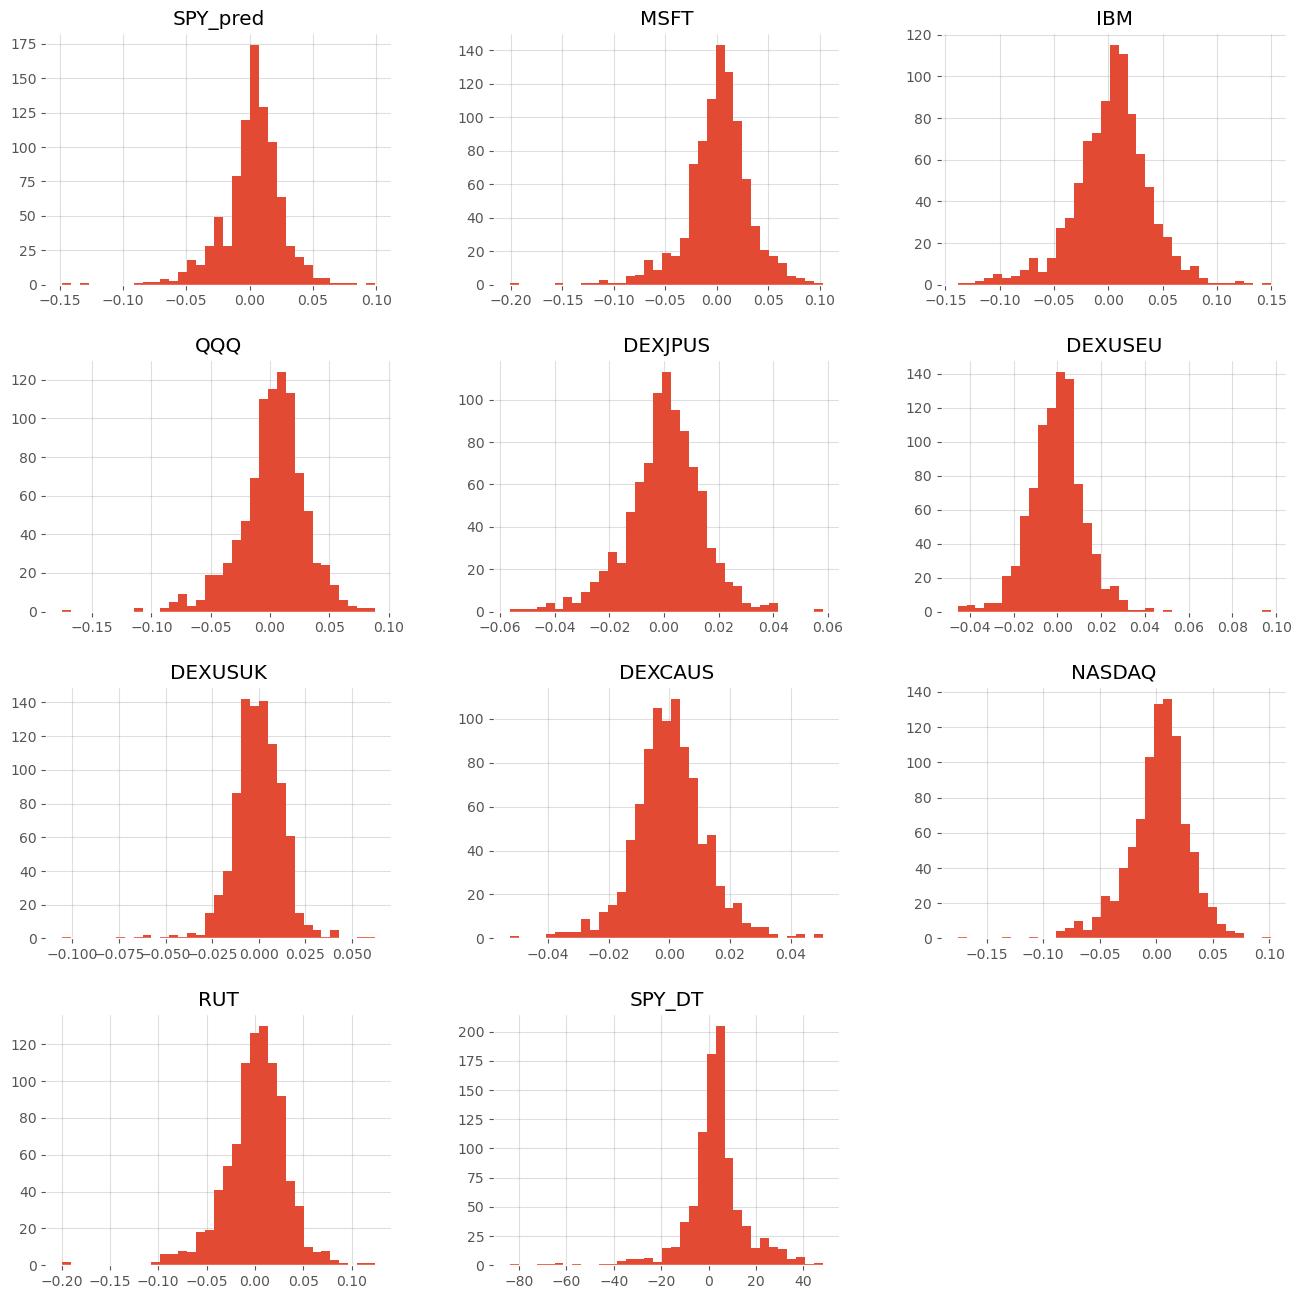

In [42]:
# Plot data distribution

(data
 .hist(bins = 35,
       sharex = False,
       sharey = False,
       figsize =[16, 16]
      )
)
plt.show()

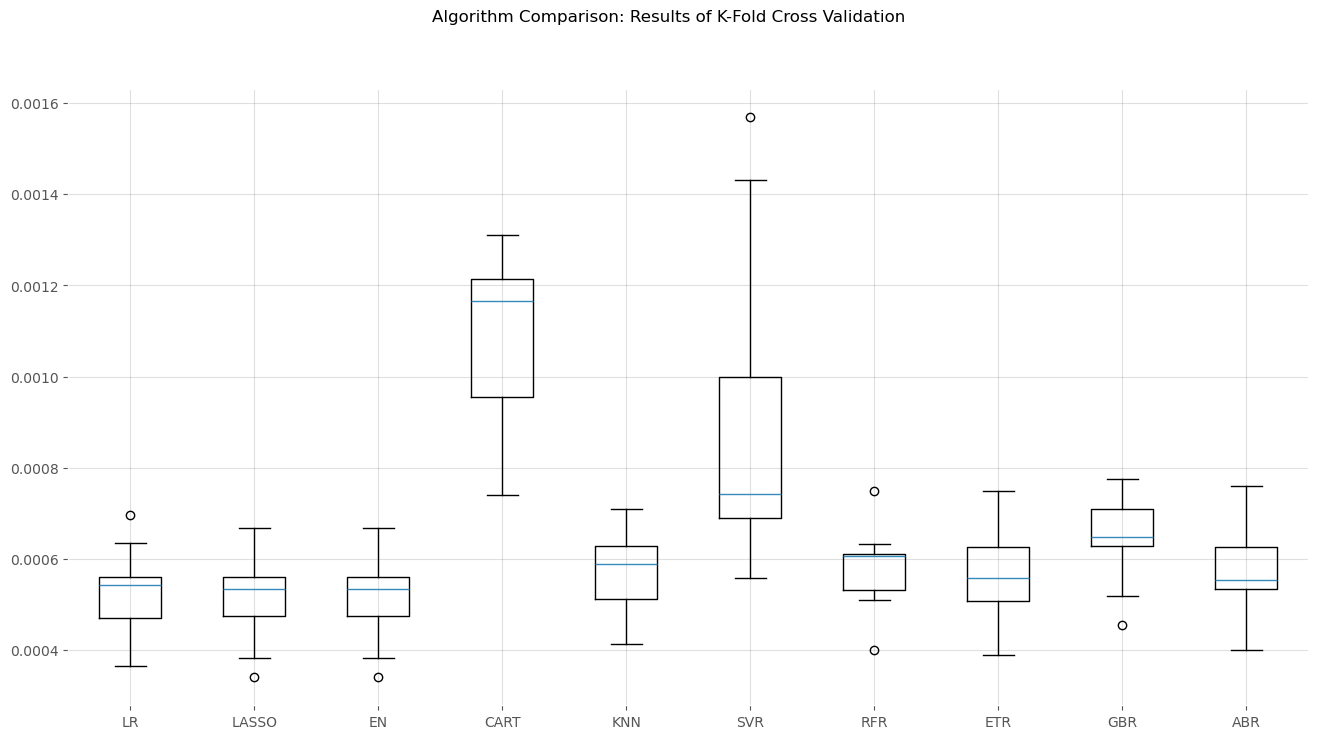

In [43]:
fig = plt.figure(figsize = [16, 8]
                )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

In [44]:
X.columns

Index(['MSFT', 'IBM', 'QQQ', 'DEXJPUS', 'DEXUSEU', 'DEXUSUK', 'DEXCAUS',
       'NASDAQ', 'RUT', 'SPY_DT'],
      dtype='object')

In [45]:
#  ARIMA Model

X_train_ARIMA =\
    (X_train
    .loc[ : , ["MSFT", "IBM", "QQQ", "DEXUSEU", "DEXUSUK", "NASDAQ", "RUT"]]
   )

X_test_ARIMA =\
    (X_test
    .loc[ : , ["MSFT", "IBM", "QQQ", "DEXUSEU", "DEXUSUK", "NASDAQ", "RUT"]]
)    

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)

In [46]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_ARIMA_model(arima_order):

    modelARIMA = stats.ARIMA(endog = Y_train,
                             exog = X_train_ARIMA,
                             order = arima_order)

    model_fit = modelARIMA.fit()

    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)

    return error

def assess_models(p_values, d_values, q_values):

    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order

                    print("ARIMA%s MSE = %.7f" % (order, mse)
                          )

                except:
                    continue
    print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
          )

# parameters to use for assessment

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)

In [47]:
assess_models(p_values, d_values, q_values)

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0) MSE = 0.0004954


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1) MSE = 0.0004946


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0) MSE = 0.0008075


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

ARIMA(0, 1, 1) MSE = 0.0005056


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

ARIMA(1, 0, 0) MSE = 0.0004944
ARIMA(1, 0, 1) MSE = 0.0004935


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

ARIMA(1, 1, 0) MSE = 0.0007220


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

ARIMA(1, 1, 1) MSE = 0.0005162


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

ARIMA(2, 0, 0) MSE = 0.0004942


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

ARIMA(2, 0, 1) MSE = 0.0004942


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

ARIMA(2, 1, 0) MSE = 0.0006488
ARIMA(2, 1, 1) MSE = 0.0005170
Best ARIMA(1, 0, 1) MSE = 0.0004935


/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
modelARIMA =\
(    stats
     .ARIMA(endog = Y_train,
                exog = X_train_ARIMA,
                order = [1, 0, 1]
            )
)

model_fit = modelARIMA.fit()

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [49]:
error_training_ARIMA =\
(    mean_squared_error(Y_train,
                       model_fit.fittedvalues)
)

predicted =\
(
    model_fit
    .predict(start = train_len - 1,
             end = total_len - 1,
             exog = X_test_ARIMA)[1: ]
)

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [50]:
error_testing_ARIMA =\
(    mean_squared_error(Y_test,
                        predicted)
)

error_testing_ARIMA

0.0006620425478804202

In [51]:
predicted.index = Y_test.index

predicted_test["ARIMA"] = predicted

test_results.append(error_testing_ARIMA)

train_results.append(error_training_ARIMA)

names.append("ARIMA")

ARIMA_predict = pd.DataFrame(model_fit.predict(start = train_len - 1,
                 end = total_len - 2,
                 exog = X_test_ARIMA[1: ]))

ARIMA_predict = np.array(ARIMA_predict)
test_df.loc[:, 'ARIMA'] = ARIMA_predict
test_df.head()

/Applications/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


LR     LASSO        EN      CART       KNN       SVR  \
2020-01-31 -0.004630  0.001892  0.001892 -0.007624 -0.000665  0.017564   
2020-02-07 -0.007875  0.001892  0.001892 -0.042876  0.010770 -0.000484   
2020-02-14  0.002109  0.001892  0.001892 -0.007642 -0.005858 -0.000271   
2020-02-25  0.013643  0.001892  0.001892 -0.008243  0.014301  0.034622   
2020-03-03  0.016113  0.001892  0.001892  0.027910  0.031050 -0.002723   

                 RFR       ETR       GBR       ABR     ARIMA  
2020-01-31 -0.004553 -0.004007 -0.007648 -0.005155 -0.005051  
2020-02-07 -0.006941 -0.000634  0.005559 -0.004747 -0.004015  
2020-02-14 -0.001702 -0.002292  0.004326 -0.001118  0.002085  
2020-02-25  0.001233  0.006116  0.006940  0.001297  0.008440  
2020-03-03  0.016180  0.023645  0.041329  0.003435  0.012212

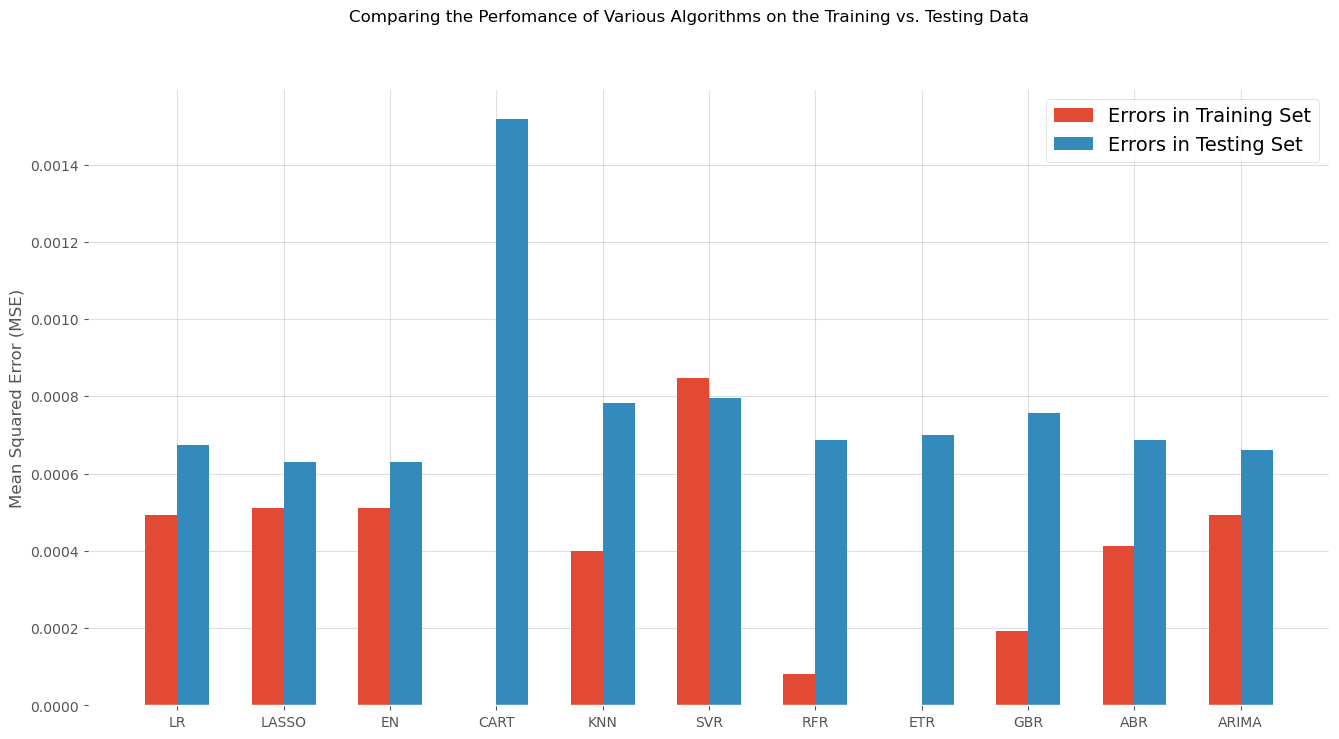

In [52]:
fig = plt.figure(figsize = [16, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
      train_results,
      width = width,
      label = "Errors in Training Set")
)

(plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

In [53]:
Y = pd.DataFrame(Y_test)

# Initialize an empty list to store model names
model_names = []

for model_name, model in models:
    # Fit the model to the training data
    model_fit = model.fit(X_train, Y_train)
    
    # Predict using the model on the test dataset
    predictions = model_fit.predict(X_test)
    
    # Convert predictions to a DataFrame and ensure it aligns with the index of Y_test
    predictions_df = pd.DataFrame(predictions, index=Y_test.index)
    
    # Store the sign of each prediction (+1, -1, or 0)
    Y[model_name] = np.sign(predictions_df)
    
    # Append the model name to the list
    model_names.append(model_name)

Y

SPY_pred   LR  LASSO   EN  CART  KNN  SVR  RFR  ETR  GBR  ABR
2020-01-31  0.032025 -1.0    1.0  1.0   1.0 -1.0  1.0 -1.0 -1.0 -1.0 -1.0
2020-02-07  0.016125 -1.0    1.0  1.0  -1.0  1.0 -1.0 -1.0 -1.0  1.0 -1.0
2020-02-14 -0.046007  1.0    1.0  1.0  -1.0 -1.0 -1.0 -1.0 -1.0  1.0 -1.0
2020-02-25 -0.040502  1.0    1.0  1.0  -1.0  1.0  1.0  1.0  1.0  1.0  1.0
2020-03-03 -0.040164  1.0    1.0  1.0   1.0  1.0 -1.0  1.0  1.0  1.0  1.0
...              ...  ...    ...  ...   ...  ...  ...  ...  ...  ...  ...
2024-09-23  0.007154 -1.0    1.0  1.0   1.0  1.0  1.0  1.0 -1.0  1.0  1.0
2024-09-30 -0.010442 -1.0    1.0  1.0  -1.0  1.0  1.0  1.0  1.0  1.0 -1.0
2024-10-07  0.028680  1.0    1.0  1.0  -1.0  1.0  1.0  1.0  1.0  1.0 -1.0
2024-10-15  0.006087 -1.0    1.0  1.0   1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0
2024-10-23  0.003489 -1.0    1.0  1.0   1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0

[227 rows x 11 columns]

In [54]:
spy_log = Y_test.to_frame(name='spy_predictions')
spy_log['capital'] = 100000  # Initial capital set to $100,000

# Calculate position based on the sign of SPY predictions
spy_log['position'] = np.sign(spy_log['spy_predictions'])

# Strategy calculation using vectorized operations
spy_log['strategy_returns'] = spy_log['spy_predictions'] * spy_log['position']

# Calculate Sharpe ratio using vectorized operations
spy_sharpe_ratio = np.sqrt(252) * (spy_log['spy_predictions'].mean() / spy_log['spy_predictions'].std())

# Update capital based on the strategy
spy_log['cumulative_capital'] = spy_log['capital'] * (spy_log['spy_predictions'].apply(np.exp).cumprod())

# Calculate the number of days between the first and the last index
spy_period_days = (spy_log.index[-1] - spy_log.index[0]).days

# Calculate Compound Annual Growth Rate (CAGR)
spy_cagr = (spy_log['cumulative_capital'].iloc[-1] / spy_log['cumulative_capital'].iloc[0])**(365.0 / spy_period_days) - 1

# Calculate the rolling maximum of the capital over the window
spy_rolling_max = spy_log['cumulative_capital'].rolling(window=253, min_periods=1).max()

# Calculate daily drawdown and maximum daily drawdown
spy_daily_drawdown = spy_log['cumulative_capital'] / spy_rolling_max - 1.0
spy_max_drawdown = spy_daily_drawdown.rolling(window=253, min_periods=1).min()

# Prepare final metrics output
spy_performance_metrics = f"SPY| Capital: {spy_log['cumulative_capital'].iloc[-1]:.2f} Sharpe: {spy_sharpe_ratio:.3f} CAGR: {spy_cagr:.3f} Max Drawdown: {spy_max_drawdown.min():.3f}"
print(spy_performance_metrics)

# Return the dataframe with the new calculations
spy_log


SPY| Capital: 204224.65 Sharpe: 1.990 CAGR: 0.155 Max Drawdown: -0.253


spy_predictions  capital  position  strategy_returns  \
2020-01-31         0.032025   100000       1.0          0.032025   
2020-02-07         0.016125   100000       1.0          0.016125   
2020-02-14        -0.046007   100000      -1.0          0.046007   
2020-02-25        -0.040502   100000      -1.0          0.040502   
2020-03-03        -0.040164   100000      -1.0          0.040164   
...                     ...      ...       ...               ...   
2024-09-23         0.007154   100000       1.0          0.007154   
2024-09-30        -0.010442   100000      -1.0          0.010442   
2024-10-07         0.028680   100000       1.0          0.028680   
2024-10-15         0.006087   100000       1.0          0.006087   
2024-10-23         0.003489   100000       1.0          0.003489   

            cumulative_capital  
2020-01-31       103254.299429  
2020-02-07       104932.723446  
2020-02-14       100214.468010  
2020-02-25        96236.658963  
2020-03-03        92447.968954  
...                        ...  
2024-09-23       198622.703166  
2024-09-30       196559.478726  
2024-10-07       202278.334833  
2024-10-15       203513.390931  
2024-10-23       204224.650696  

[227 rows x 5 columns]

# <a id = "p7">2 </a> <font color = "green"> Part 2 </font> [back to table of contents](#top)

In [55]:
capital = 1e5

### Simple Moving Average (Long Only) Strategy Performance

Ending capital is $654,724.96
Sharpe Ratio: 0.8245
Compound Annual Growth Rate (CAGR): 10.3905%
Maximum Drawdown: -3154.7157%
Drawdown Duration: 497 calendar days


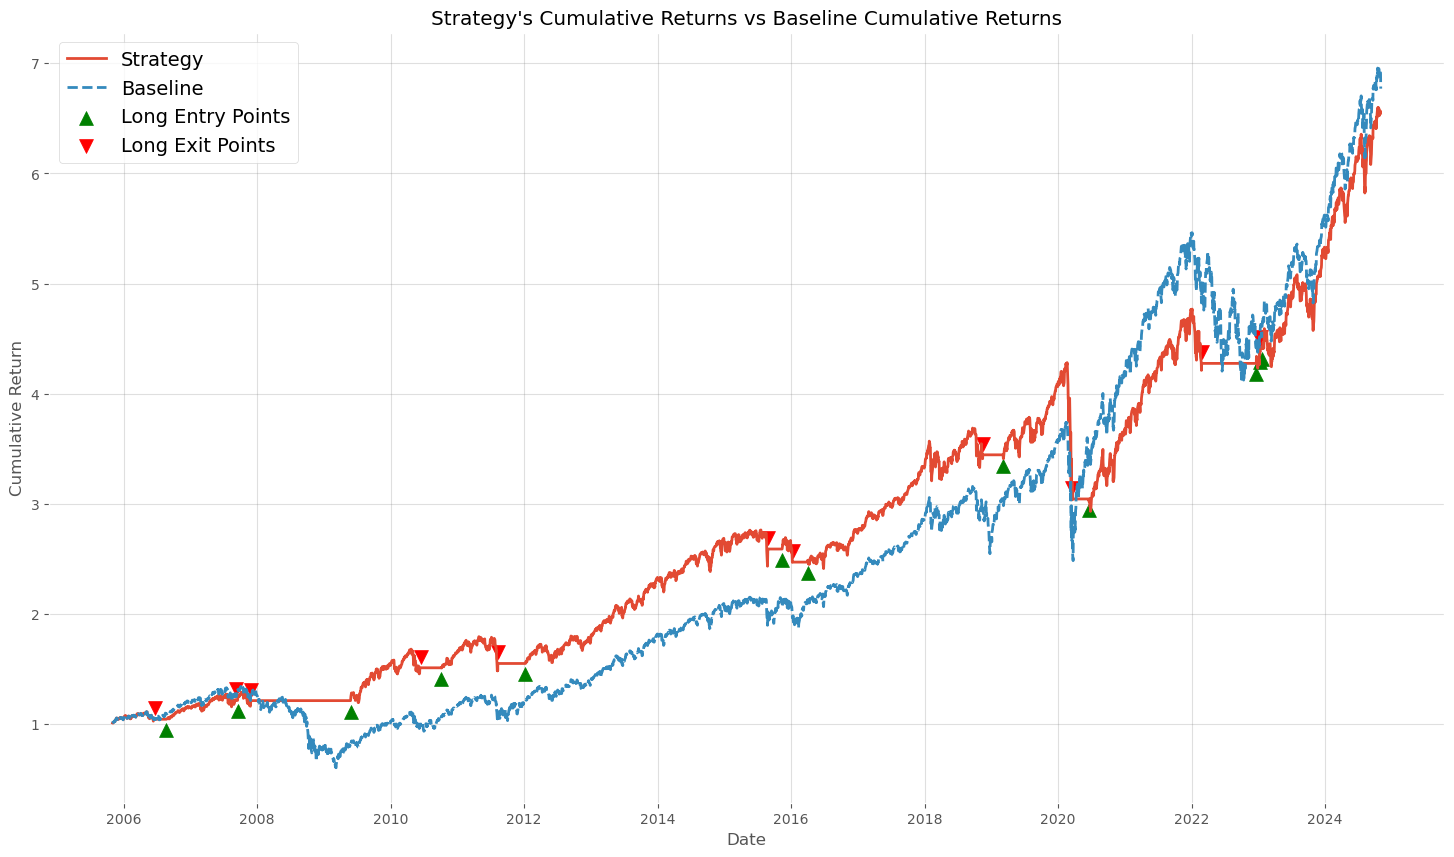

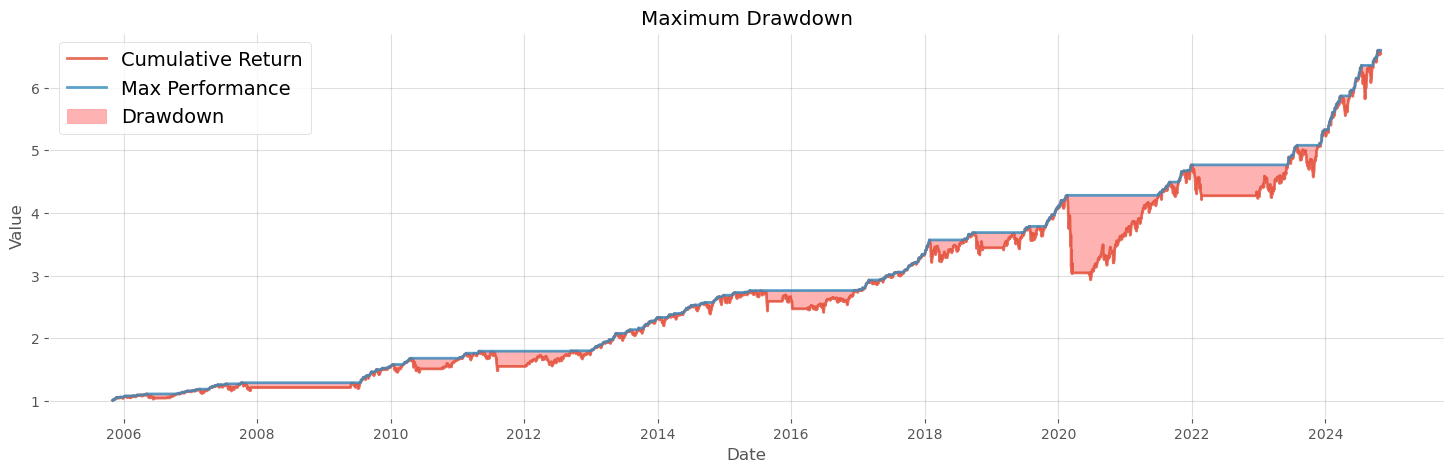

In [56]:
SMA_long = strategy_ret_summary(stk_cumulative_ret(MA_strategy(spy, 
                                                               SMA_long_parameters[0], 
                                                               SMA_long_parameters[1], 
                                                               MA_method="SMA", long_only=True))
                                ,capital, no_strat_base_ret, long_only=True)

### Exponential Moving Average (Long Only) Strategy Performance

Ending capital is $626,515.99
Sharpe Ratio: 0.8779
Compound Annual Growth Rate (CAGR): 10.1351%
Maximum Drawdown: -2201.7046%
Drawdown Duration: 786 calendar days


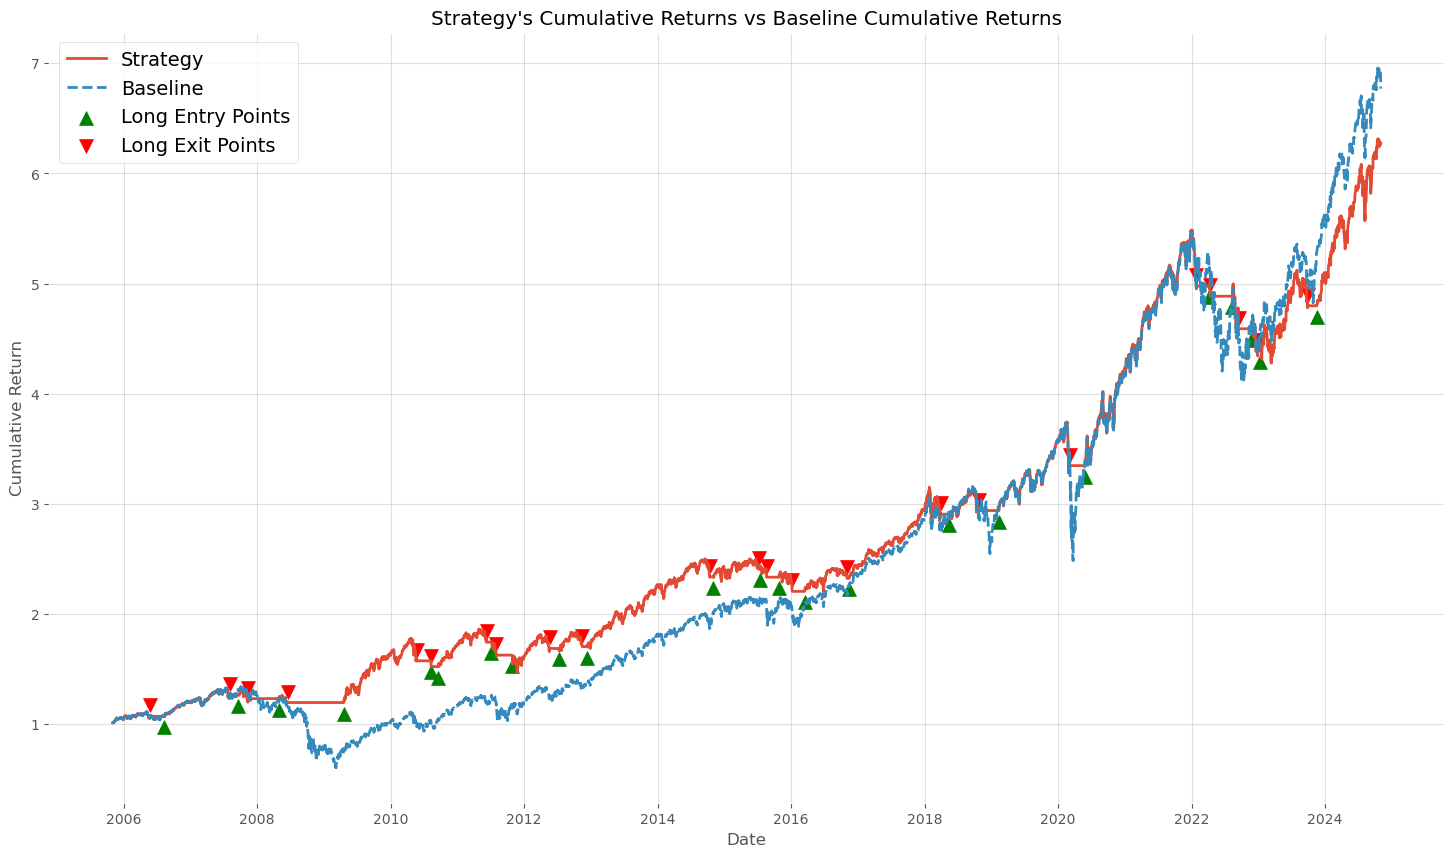

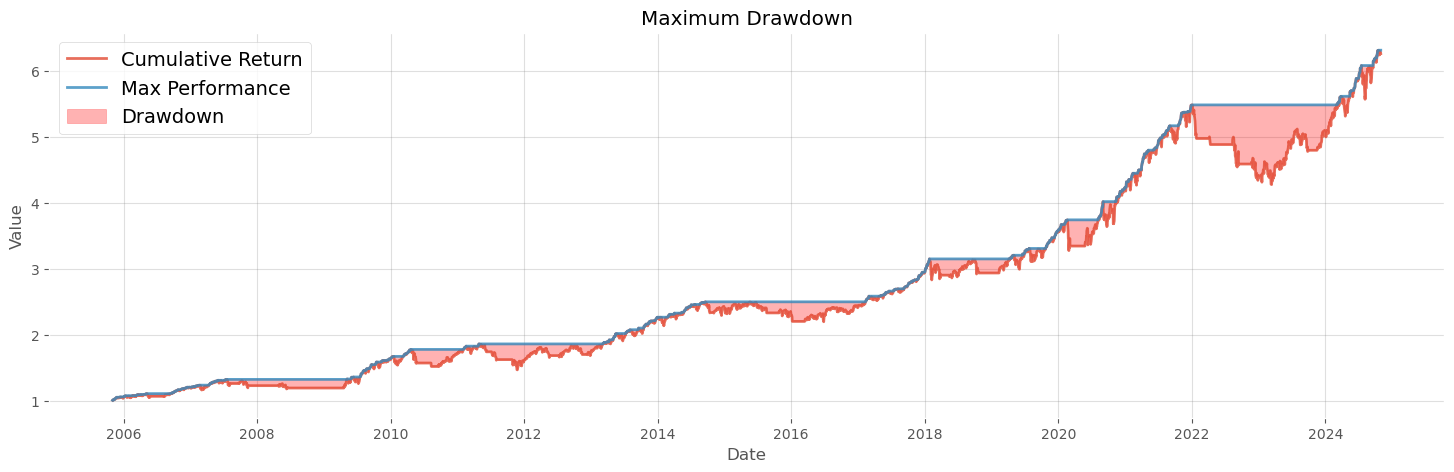

In [57]:
EMA_long = strategy_ret_summary(stk_cumulative_ret(MA_strategy(spy, 
                                                               EMA_long_parameters[0], 
                                                               EMA_long_parameters[1], 
                                                               MA_method="EMA", long_only=True))
                                ,capital, no_strat_base_ret, long_only=True)

### Simple Moving Average (Long-Short) Strategy Performance

Ending capital is $397,075.89
Sharpe Ratio: 0.4732
Compound Annual Growth Rate (CAGR): 7.5242%
Maximum Drawdown: -4971.6090%
Drawdown Duration: 1462 calendar days


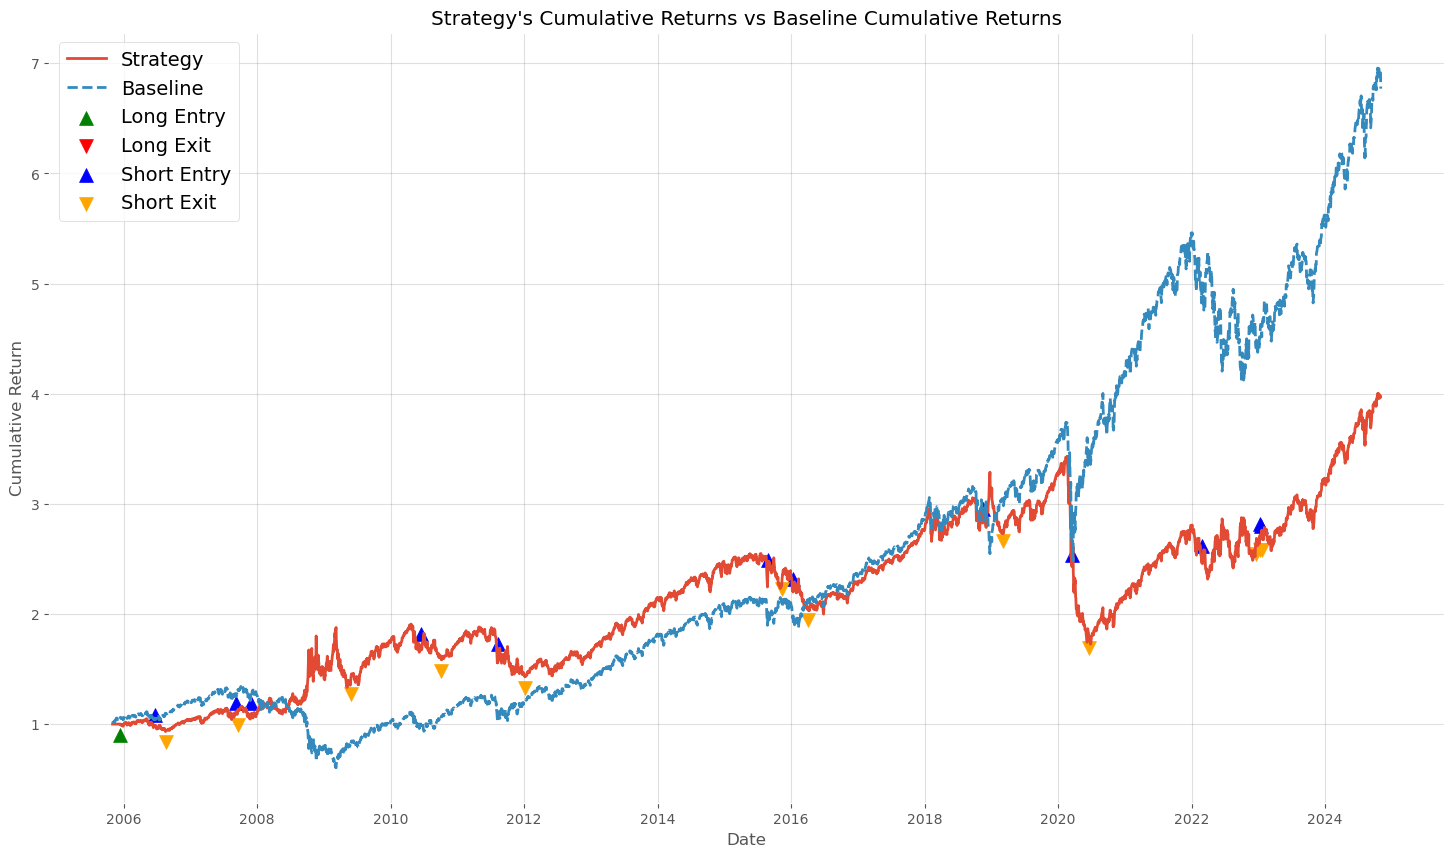

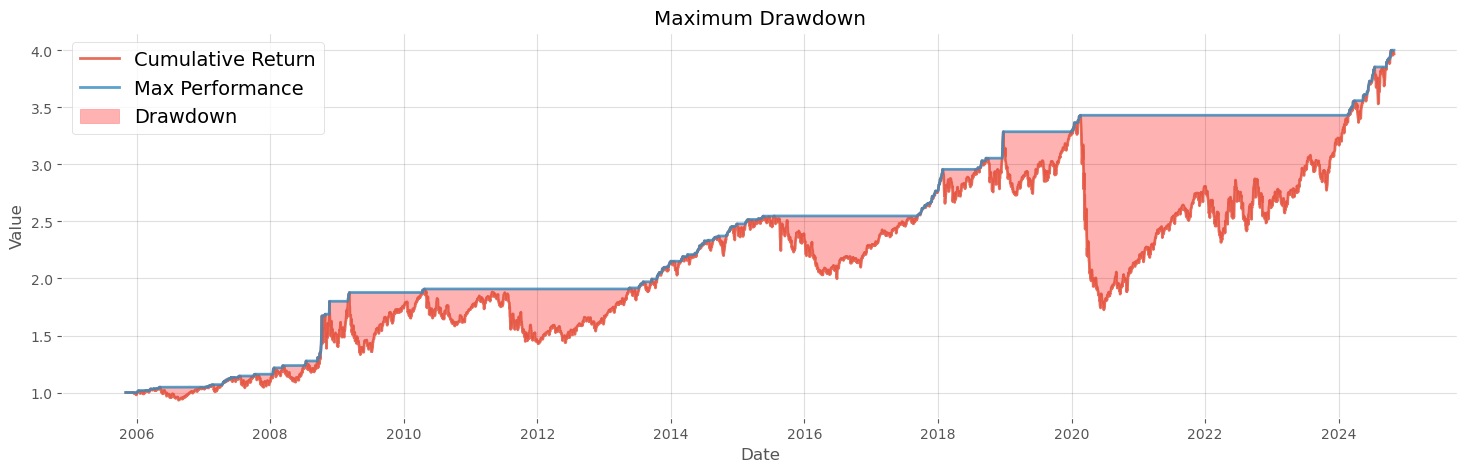

In [58]:
SMA_longshort = strategy_ret_summary(stk_cumulative_ret(MA_strategy(spy, 
                                                                    SMA_long_parameters[0], 
                                                                    SMA_long_parameters[1], 
                                                                    MA_method="SMA", 
                                                                    long_only=False)),
                                     capital, no_strat_base_ret, long_only=False)

### Exponential Moving Average (Long-Short) Strategy Performance

Ending capital is $359,904.25
Sharpe Ratio: 0.4459
Compound Annual Growth Rate (CAGR): 6.9696%
Maximum Drawdown: -3378.5448%
Drawdown Duration: 1502 calendar days


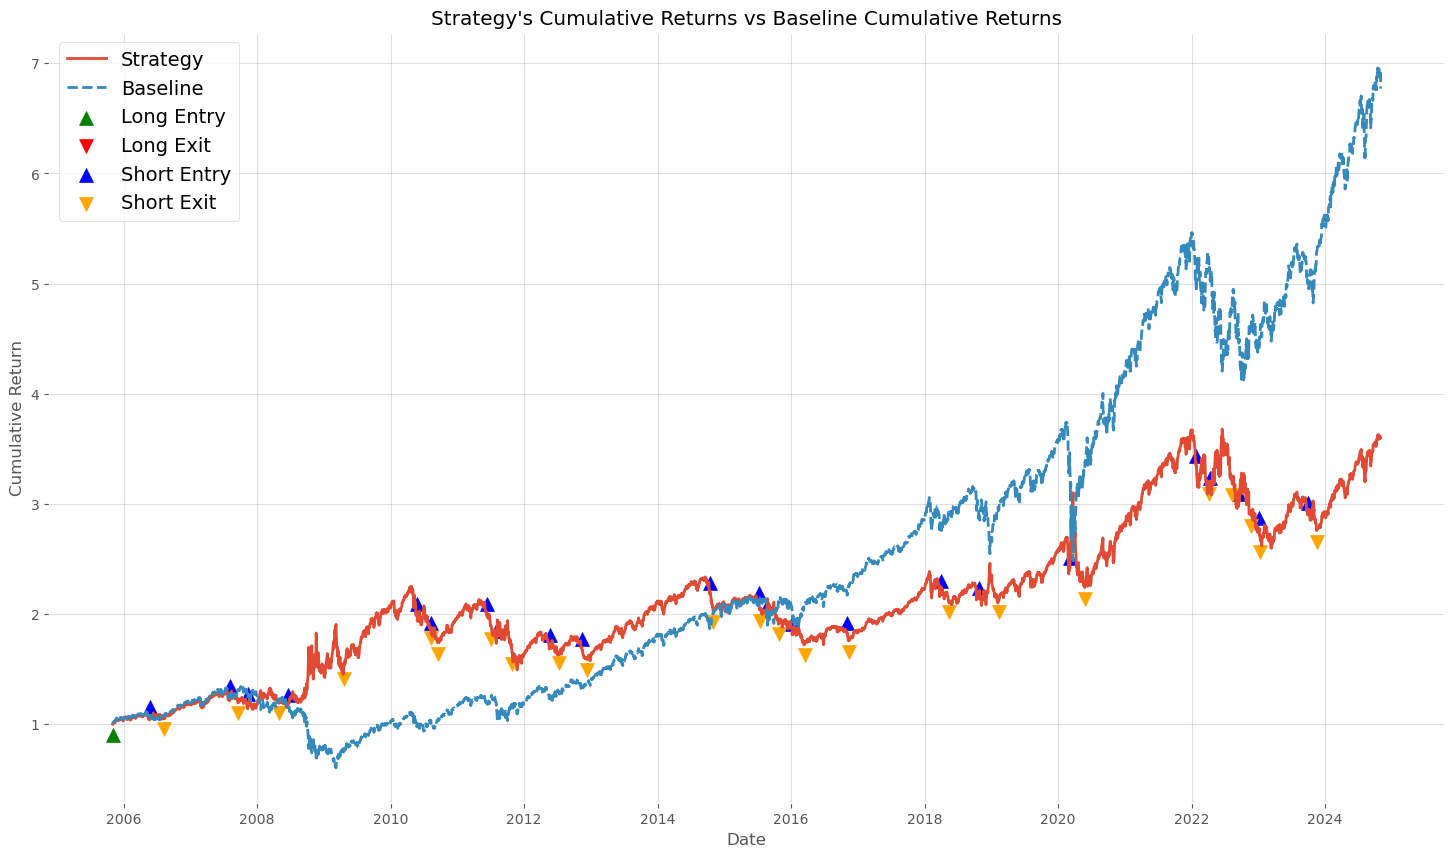

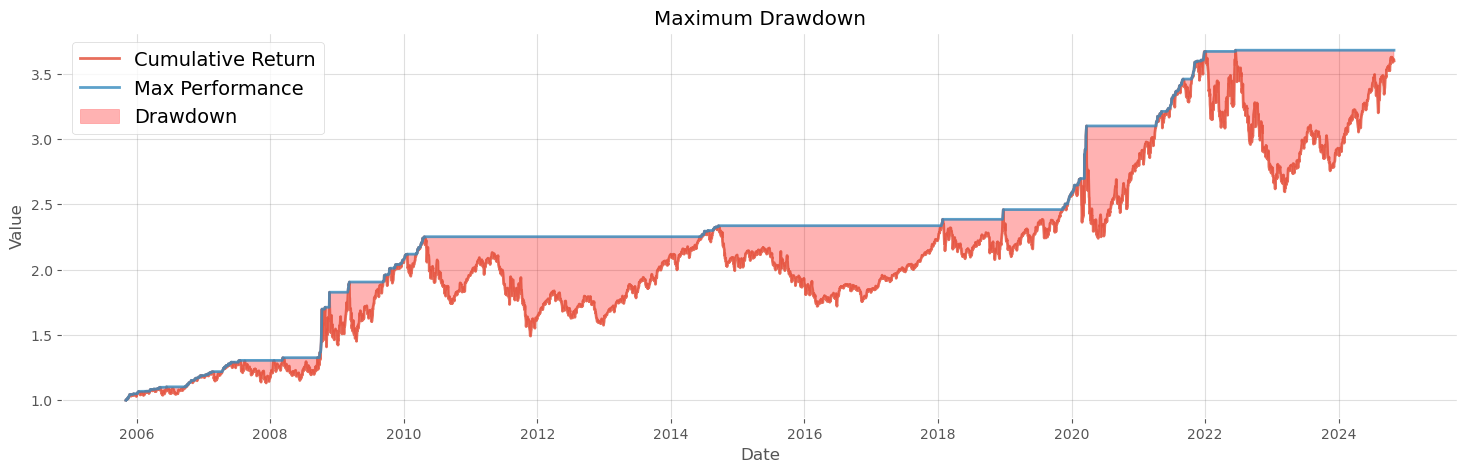

In [59]:
EMA_longshort = strategy_ret_summary(stk_cumulative_ret(MA_strategy(spy, 
                                                                    EMA_long_parameters[0], 
                                                                    EMA_long_parameters[1], 
                                                                    MA_method="EMA", 
                                                                    long_only=False)),
                                     capital, no_strat_base_ret, long_only=False)

In [60]:
short_range = (5, 25)
long_range = (10, 50)
signal_range = (5, 25)

### MACD (Long Only) Strategy Performance

MACD Parameters: (6, 50, 13)
Cumulative Return: 3.45
Ending capital is $345,268.56
Sharpe Ratio: 0.6407
Compound Annual Growth Rate (CAGR): 6.7362%
Maximum Drawdown: -2311.3573%
Drawdown Duration: 820 calendar days


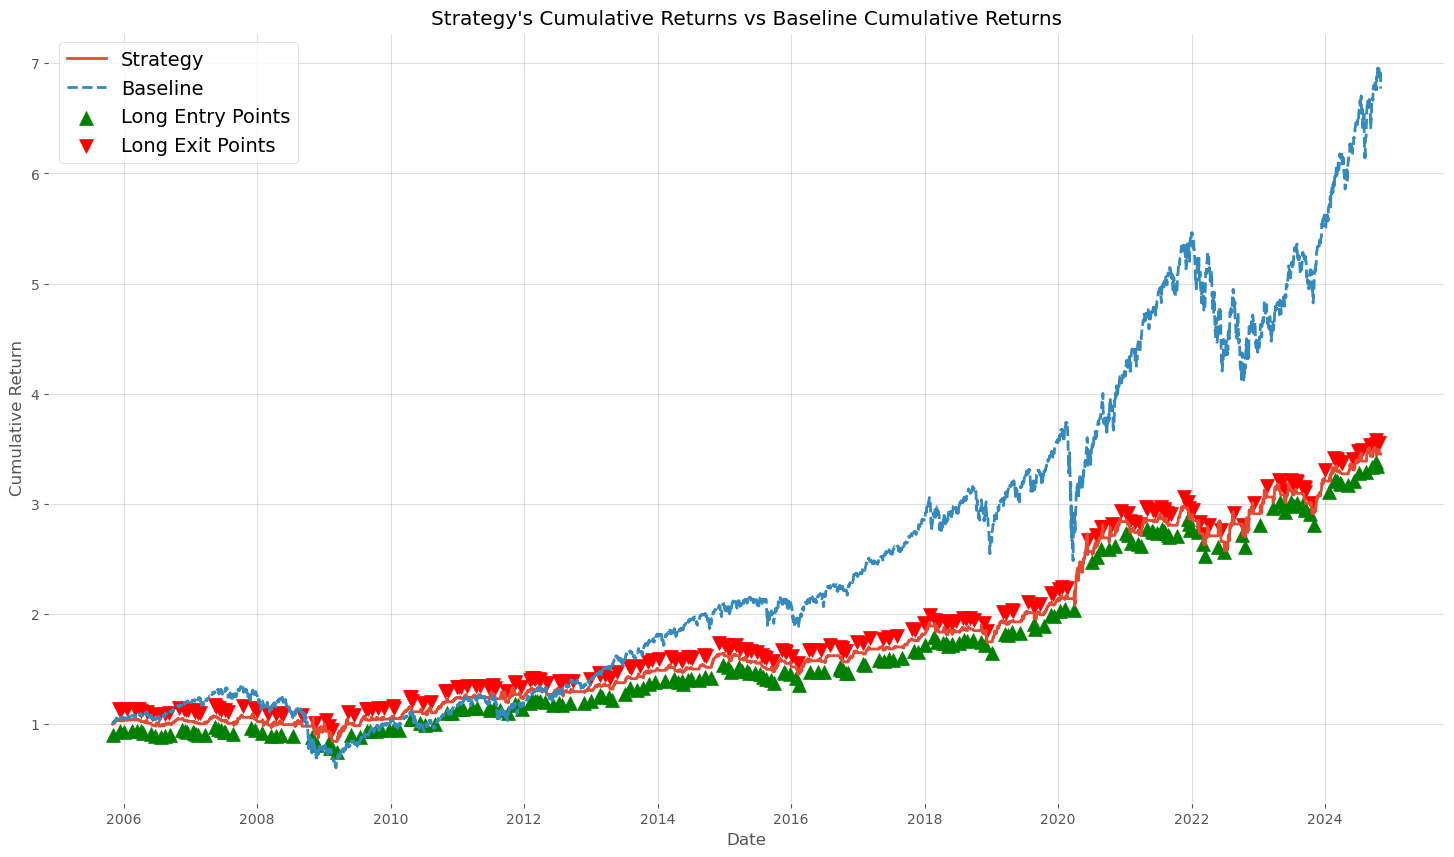

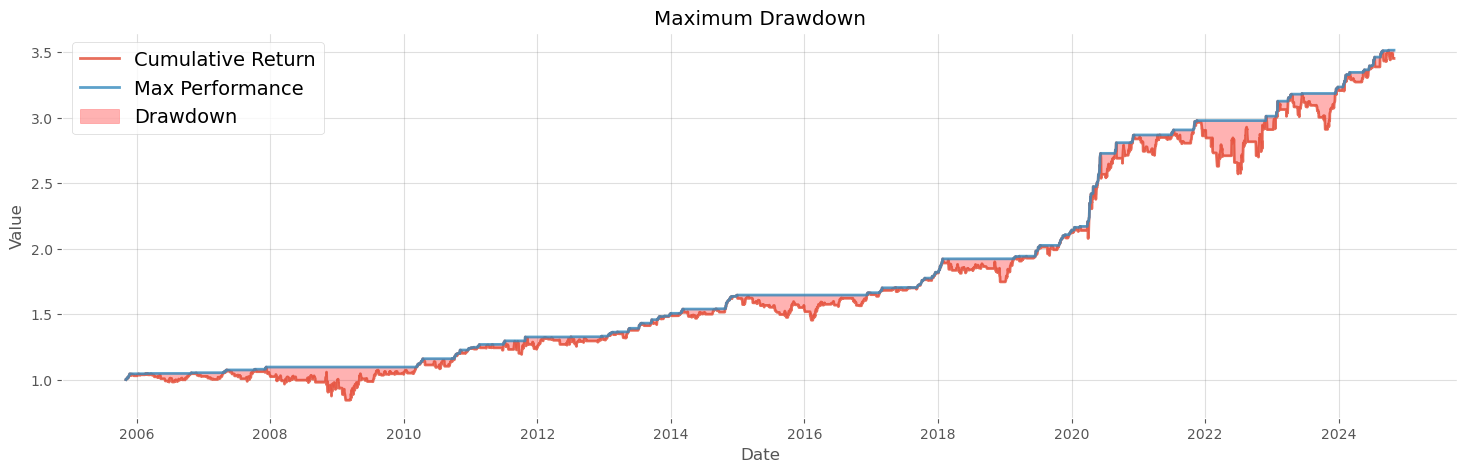

In [61]:
best_params_long, best_return_long = optimize_MACD_parameters(spy, short_range, long_range, signal_range, long_only=True)
macd_long_df = MACD_strategy(spy, best_params_long[0], best_params_long[1], best_params_long[2], long_only=True)
macd_long_df = stk_cumulative_ret(macd_long_df)
strategy_ret_summary(macd_long_df, capital, no_strat_base_ret, long_only=True)

### MACD (Long Short) Strategy Performance

MACD Parameters: (6, 50, 13)
Cumulative Return: 1.08
Ending capital is $108,479.34
Sharpe Ratio: 0.1192
Compound Annual Growth Rate (CAGR): 0.4291%
Maximum Drawdown: -3482.2987%
Drawdown Duration: 1604 calendar days


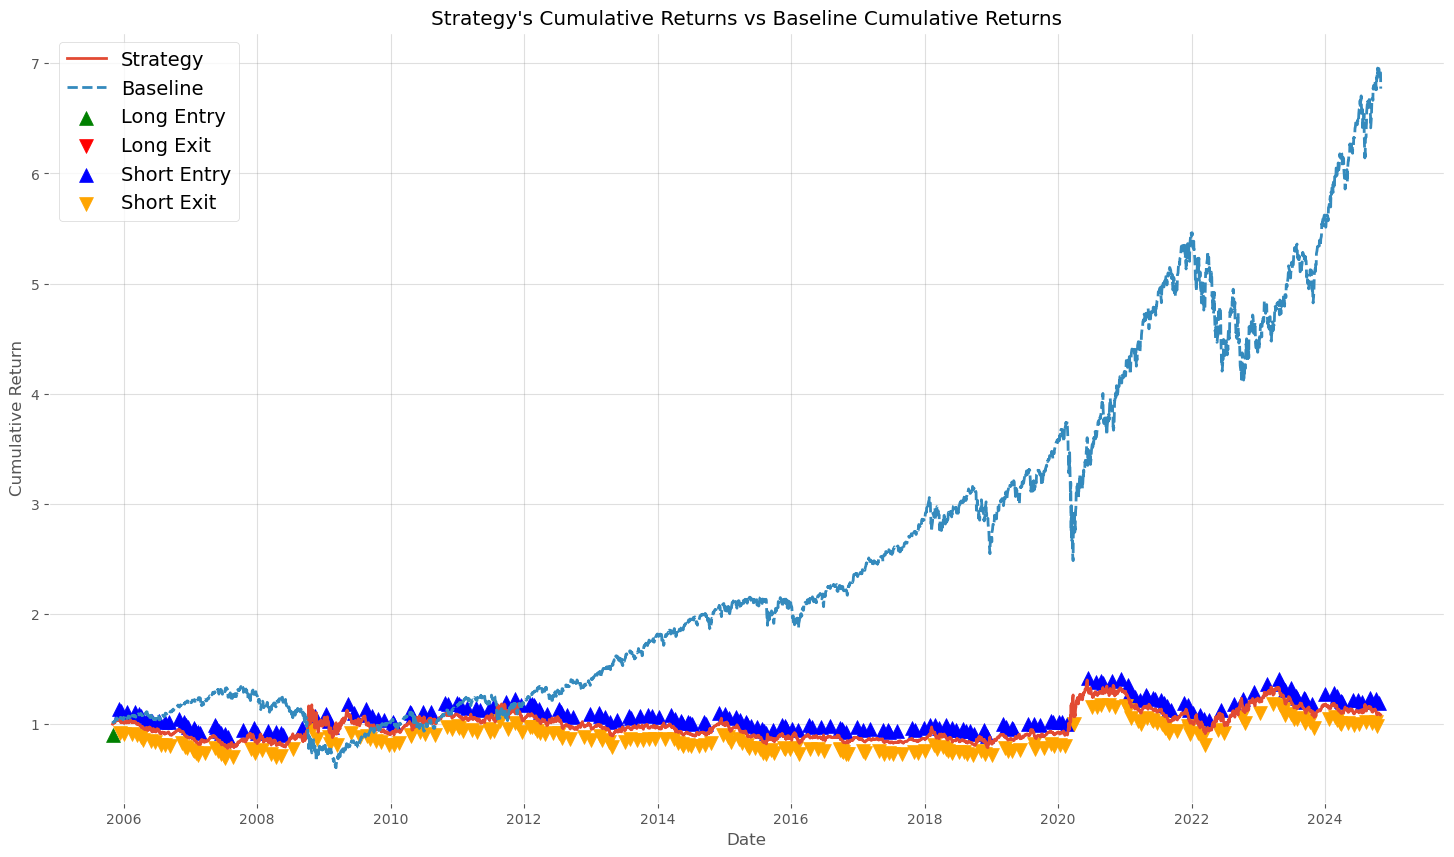

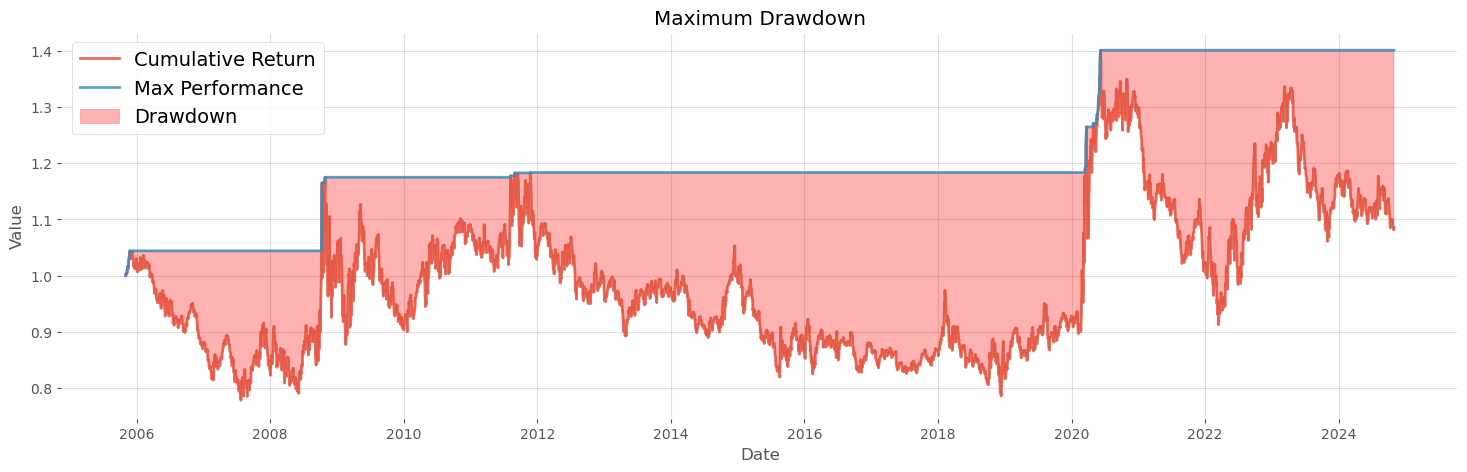

In [62]:
best_params_longshort, best_return_longshort = optimize_MACD_parameters(spy, short_range, long_range, signal_range, long_only=False)
macd_longshort_df = MACD_strategy(spy, best_params_longshort[0], best_params_longshort[1], best_params_longshort[2], long_only=False)
macd_longshort_df = stk_cumulative_ret(macd_longshort_df)
strategy_ret_summary(macd_longshort_df, capital, no_strat_base_ret, long_only=False)

In [63]:
period_range = (10, 50)
multiplier_range = (1, 3)

### Bollinger (Long Only) Strategy Performance

Bollinger Parameter: (12, 1.2000000000000002)
Cumulative Return: 3.48
Ending capital is $348,383.64
Sharpe Ratio: 0.6535
Compound Annual Growth Rate (CAGR): 6.7867%
Maximum Drawdown: -2087.6166%
Drawdown Duration: 24 calendar days


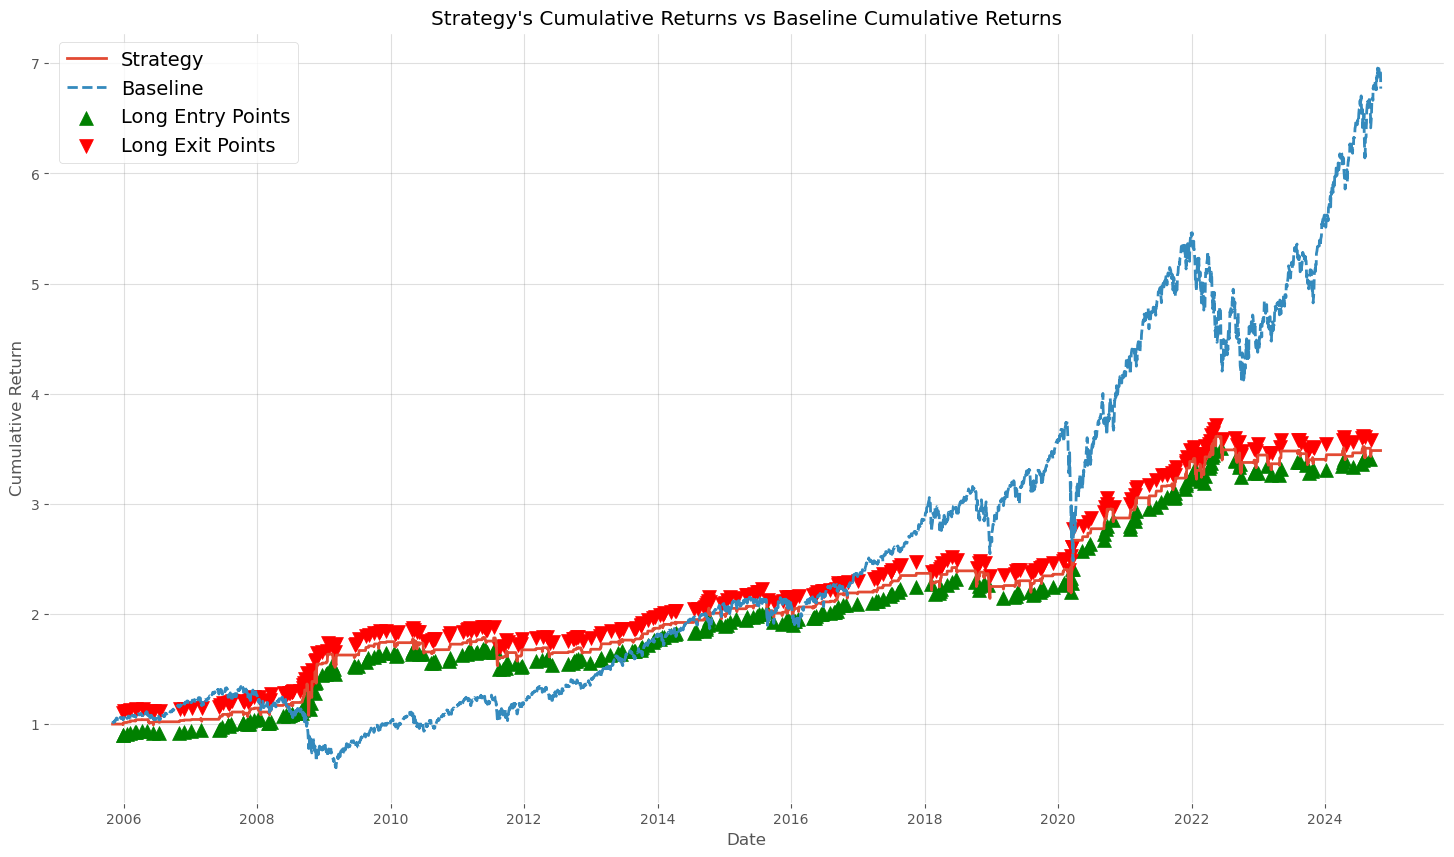

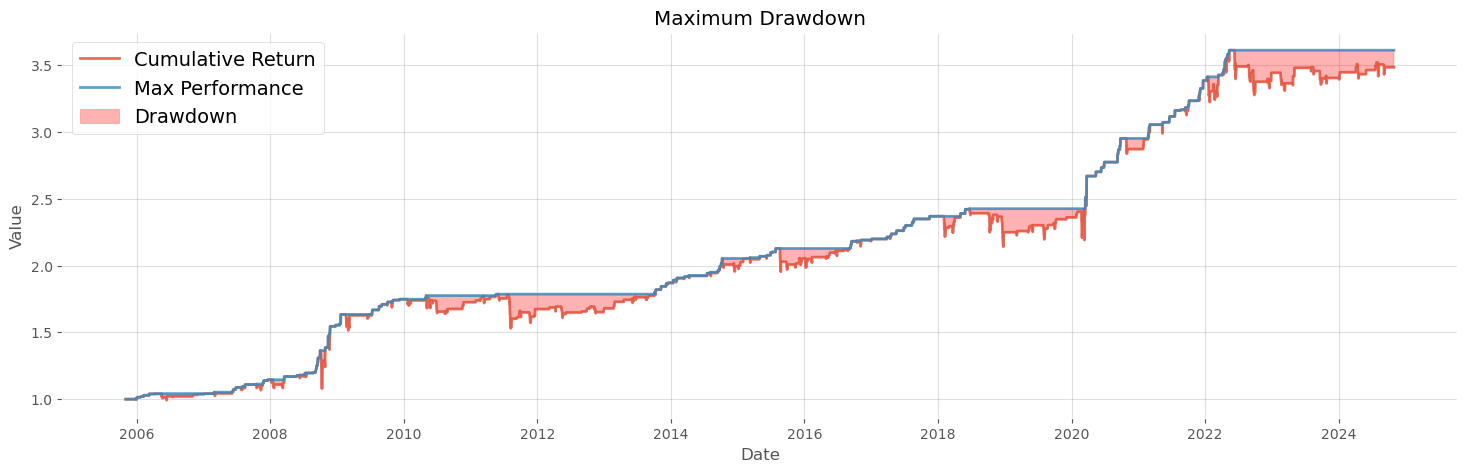

In [64]:
best_params_long, best_return_long = optimize_Bollinger_parameters(spy, period_range, multiplier_range, long_only=True)
bollinger_long_df = Bollinger_strategy(spy, best_params_long[0], best_params_long[1], long_only=True)
bollinger_long_df = stk_cumulative_ret(bollinger_long_df)
strategy_ret_summary(bollinger_long_df, capital, no_strat_base_ret, long_only=True)

### Bollinger (Long Short) Strategy Performance

Bollinger Parameter: (11, 1.4000000000000004)
Cumulative Return: 3.52
Ending capital is $352,191.41
Sharpe Ratio: 0.6558
Compound Annual Growth Rate (CAGR): 6.8478%
Maximum Drawdown: -2087.6166%
Drawdown Duration: 32 calendar days


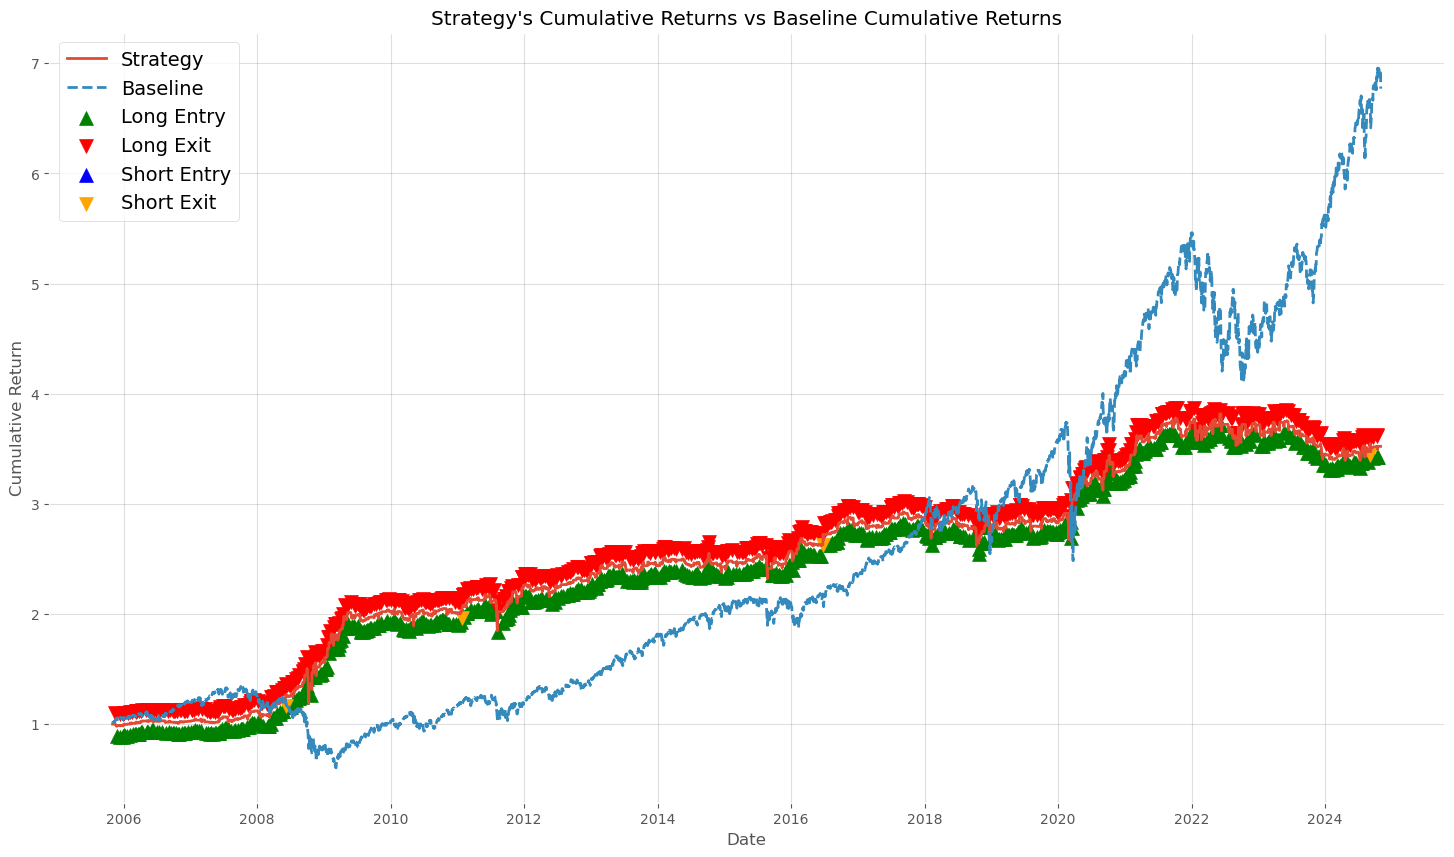

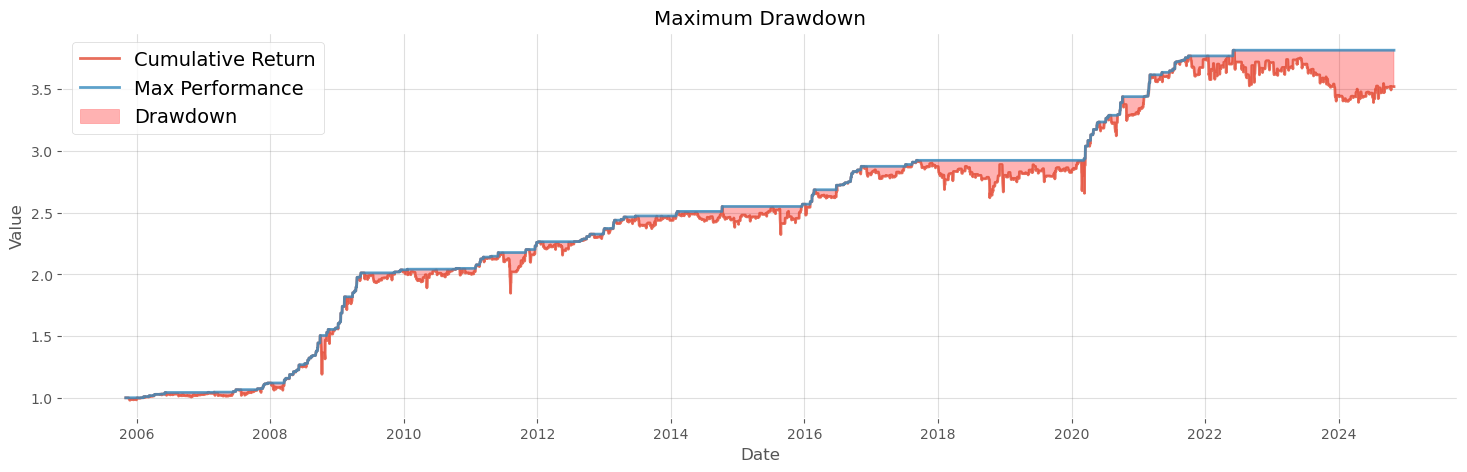

In [65]:
best_params_longshort, best_return_longshort = optimize_Bollinger_parameters(spy, period_range, multiplier_range, long_only=False)
bollinger_longshort_df = Bollinger_strategy(spy, best_params_longshort[0], best_params_longshort[1], long_only=False)
bollinger_longshort_df = stk_cumulative_ret(bollinger_longshort_df)
strategy_ret_summary(bollinger_longshort_df, capital, no_strat_base_ret, long_only=False)

In [66]:
sma_shorts = range(5, 21, 5)  
sma_longs = range(50, 201, 50)  
macd_shorts = range(5, 21, 5)  
macd_longs = range(20, 101, 20)  
macd_signals = range(5, 13, 2)  

### Combination of SMA-MACD (Long Only) Strategy Performance

Best Parameters: ((10, 200), (5, 80, 11))
Best Cumulative Return: 8.74
Ending capital is $874,237.88
Sharpe Ratio: 0.8421
Compound Annual Growth Rate (CAGR): 12.0826%
Maximum Drawdown: -2619.8743%
Drawdown Duration: 672 calendar days


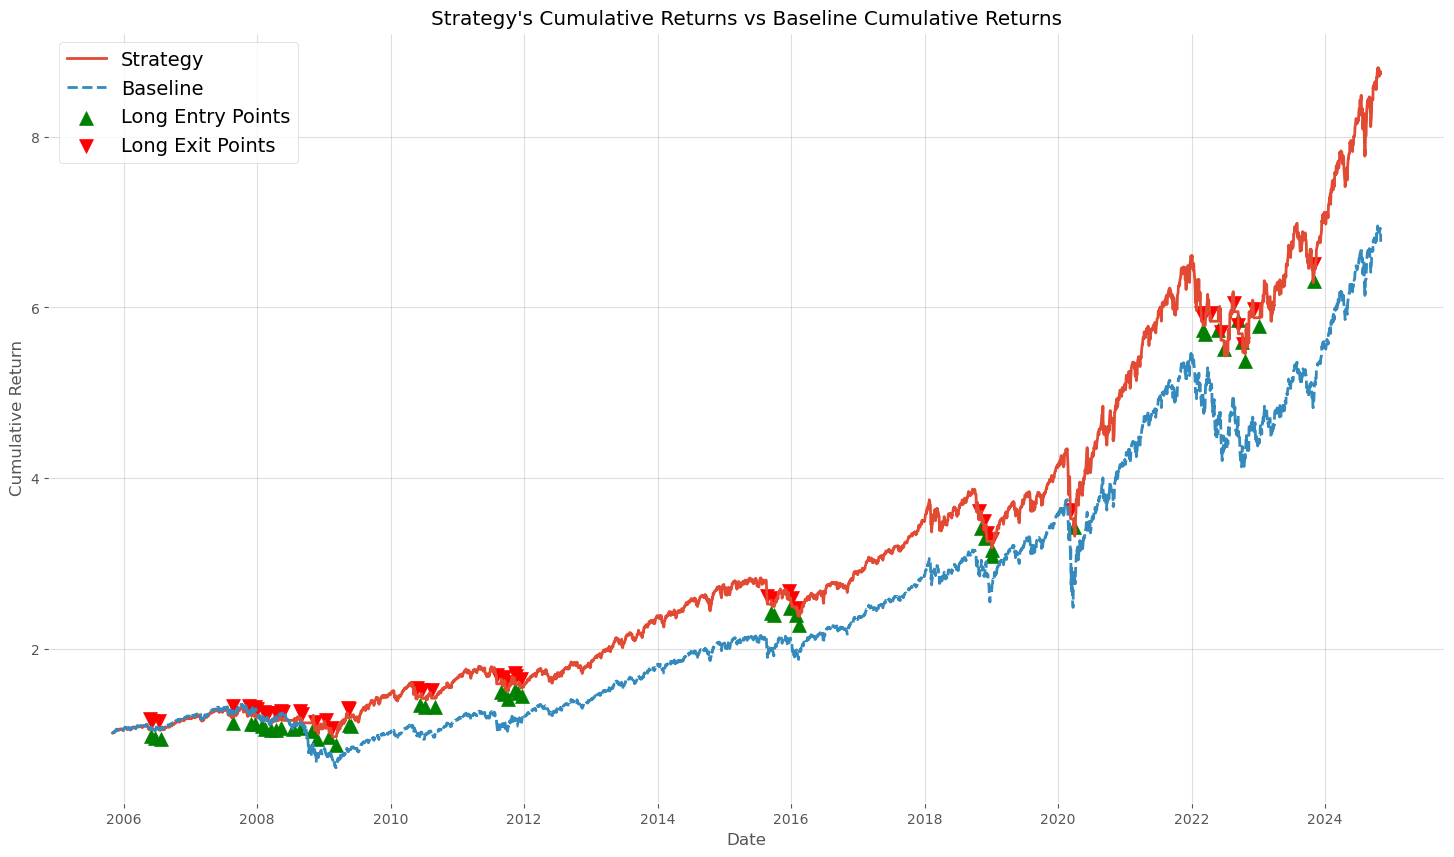

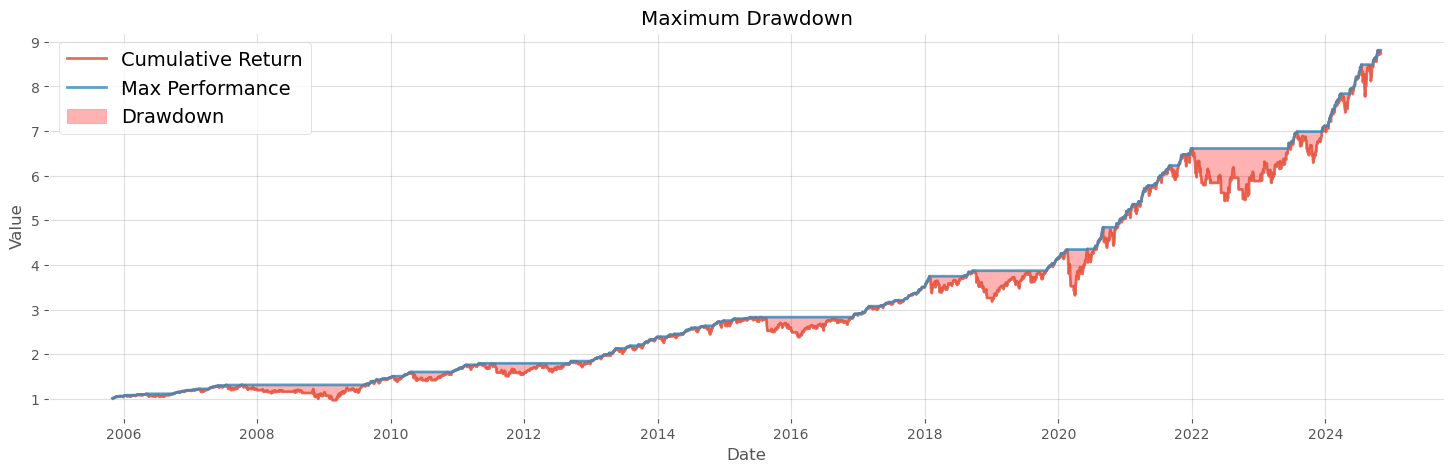

In [67]:
best_params_sma_longonly, best_return_sma_longonly = tune_combined_SMA_MACD_parameters(
    spy, sma_shorts, sma_longs, macd_shorts, macd_longs, macd_signals, sma_method="SMA", long_only=True
)
sma_longonly_df = combine_existing_SMA_MACD_strategy(
    spy, best_params_sma_longonly[0], best_params_sma_longonly[1], sma_method="SMA", long_only=True
)
sma_longonly_df = stk_cumulative_ret(sma_longonly_df)
strategy_ret_summary(sma_longonly_df, capital, no_strat_base_ret, long_only=True)

### Combination of SMA-MACD (Long Short) Strategy Performance

Best Parameters: ((10, 200), (5, 80, 11))
Best Cumulative Return: 2.00
Ending capital is $200,439.11
Sharpe Ratio: 0.3312
Compound Annual Growth Rate (CAGR): 3.7258%
Maximum Drawdown: -2137.2582%
Drawdown Duration: 1898 calendar days


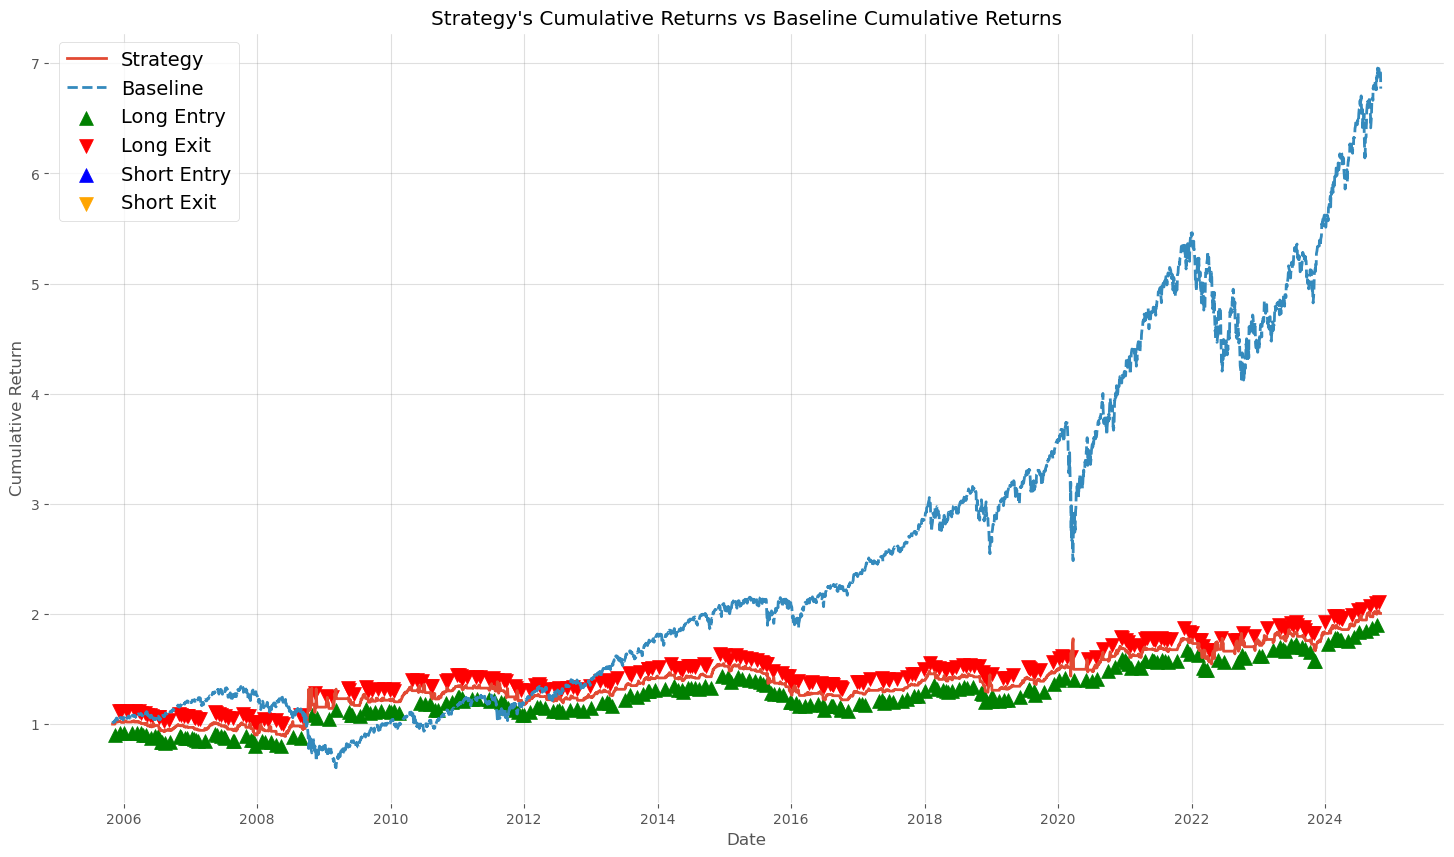

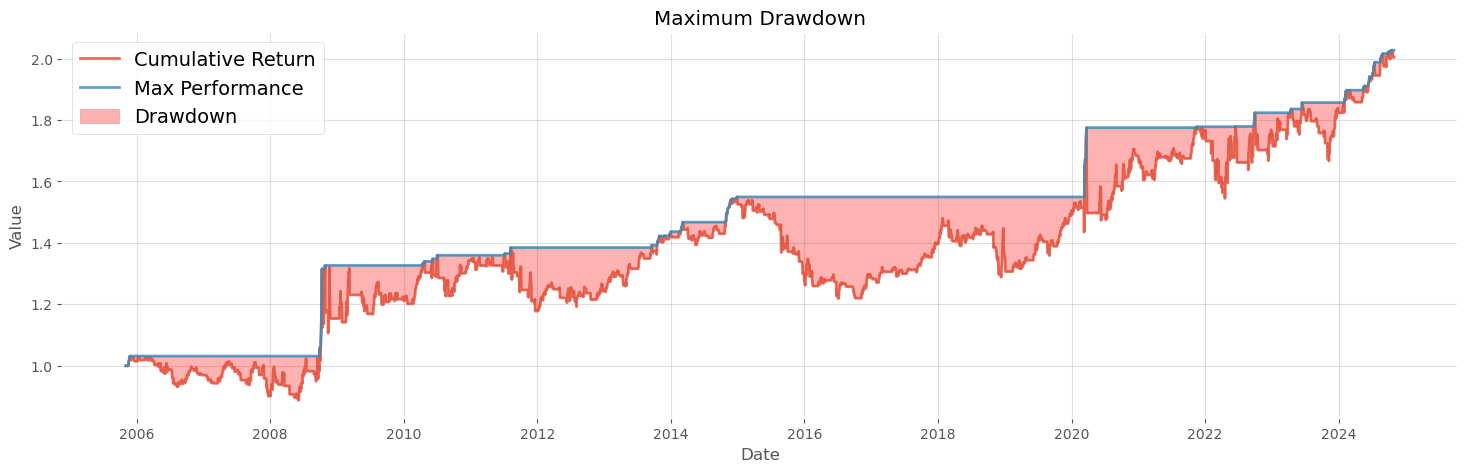

In [68]:
best_params_sma_longshort, best_return_sma_longshort = tune_combined_SMA_MACD_parameters(
    spy, sma_shorts, sma_longs, macd_shorts, macd_longs, macd_signals, sma_method="SMA", long_only=False
)
sma_longshort_df = combine_existing_SMA_MACD_strategy(
    spy, best_params_sma_longshort[0], best_params_sma_longshort[1], sma_method="SMA", long_only=False
)
sma_longshort_df = stk_cumulative_ret(sma_longshort_df)
strategy_ret_summary(sma_longshort_df, capital, no_strat_base_ret, long_only=False)

In [69]:
### Machine Learning Model Performance

LR| Capital: 106,494.38 Sharpe: 0.174 CAGR: 0.020% Max DD: -24.12%


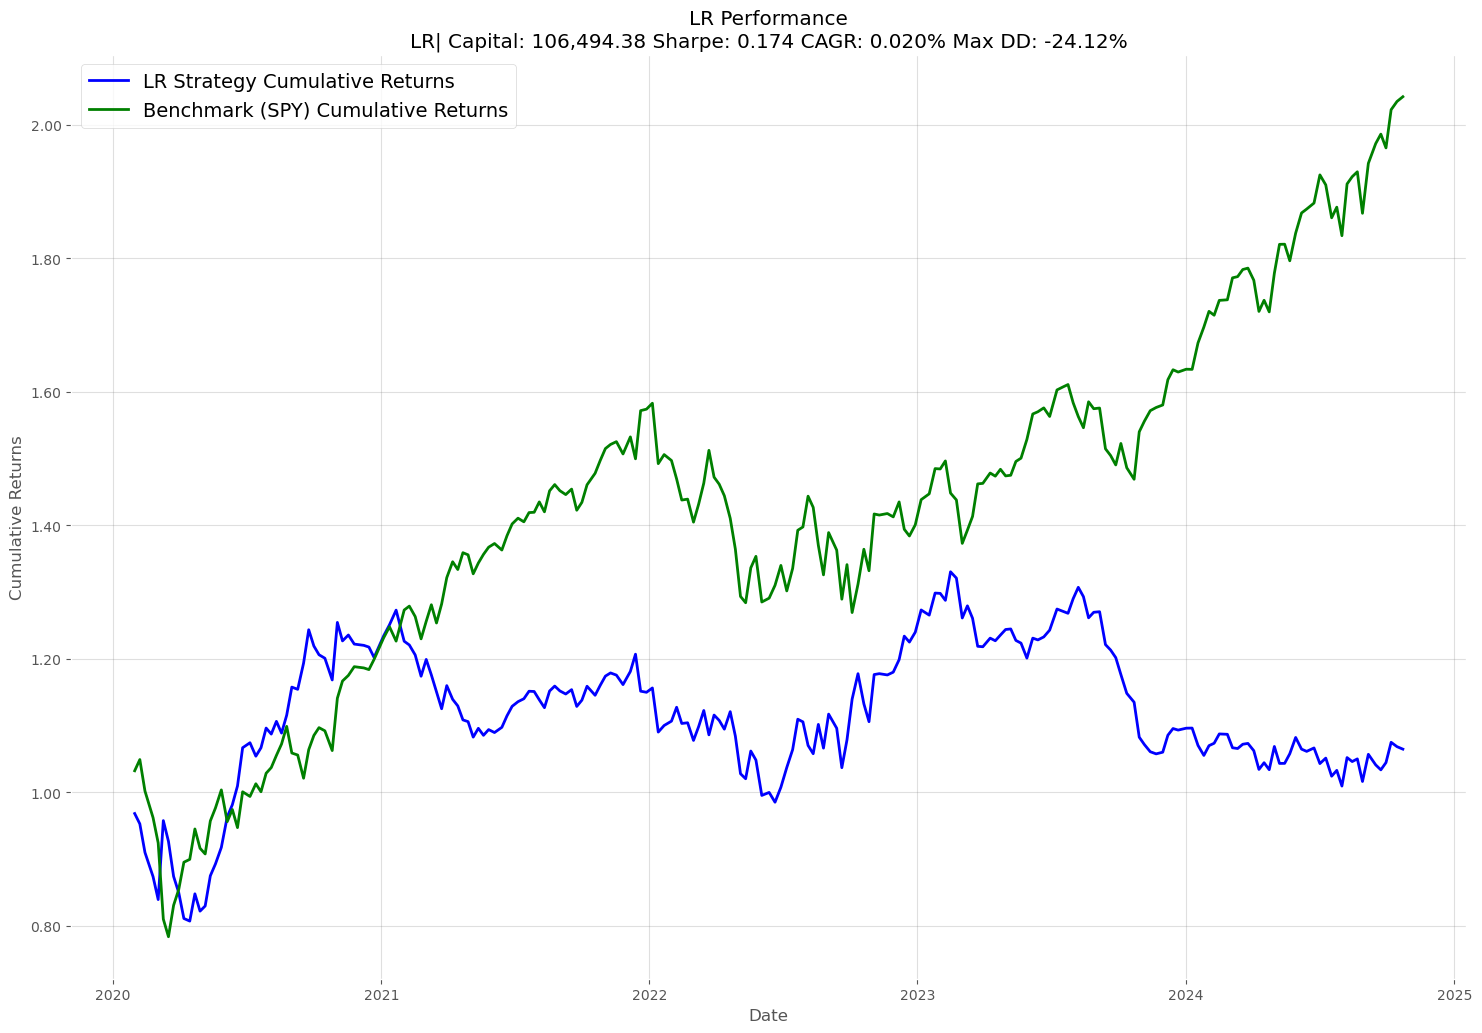

LASSO| Capital: 204,224.65 Sharpe: 1.994 CAGR: 0.155% Max DD: -25.29%


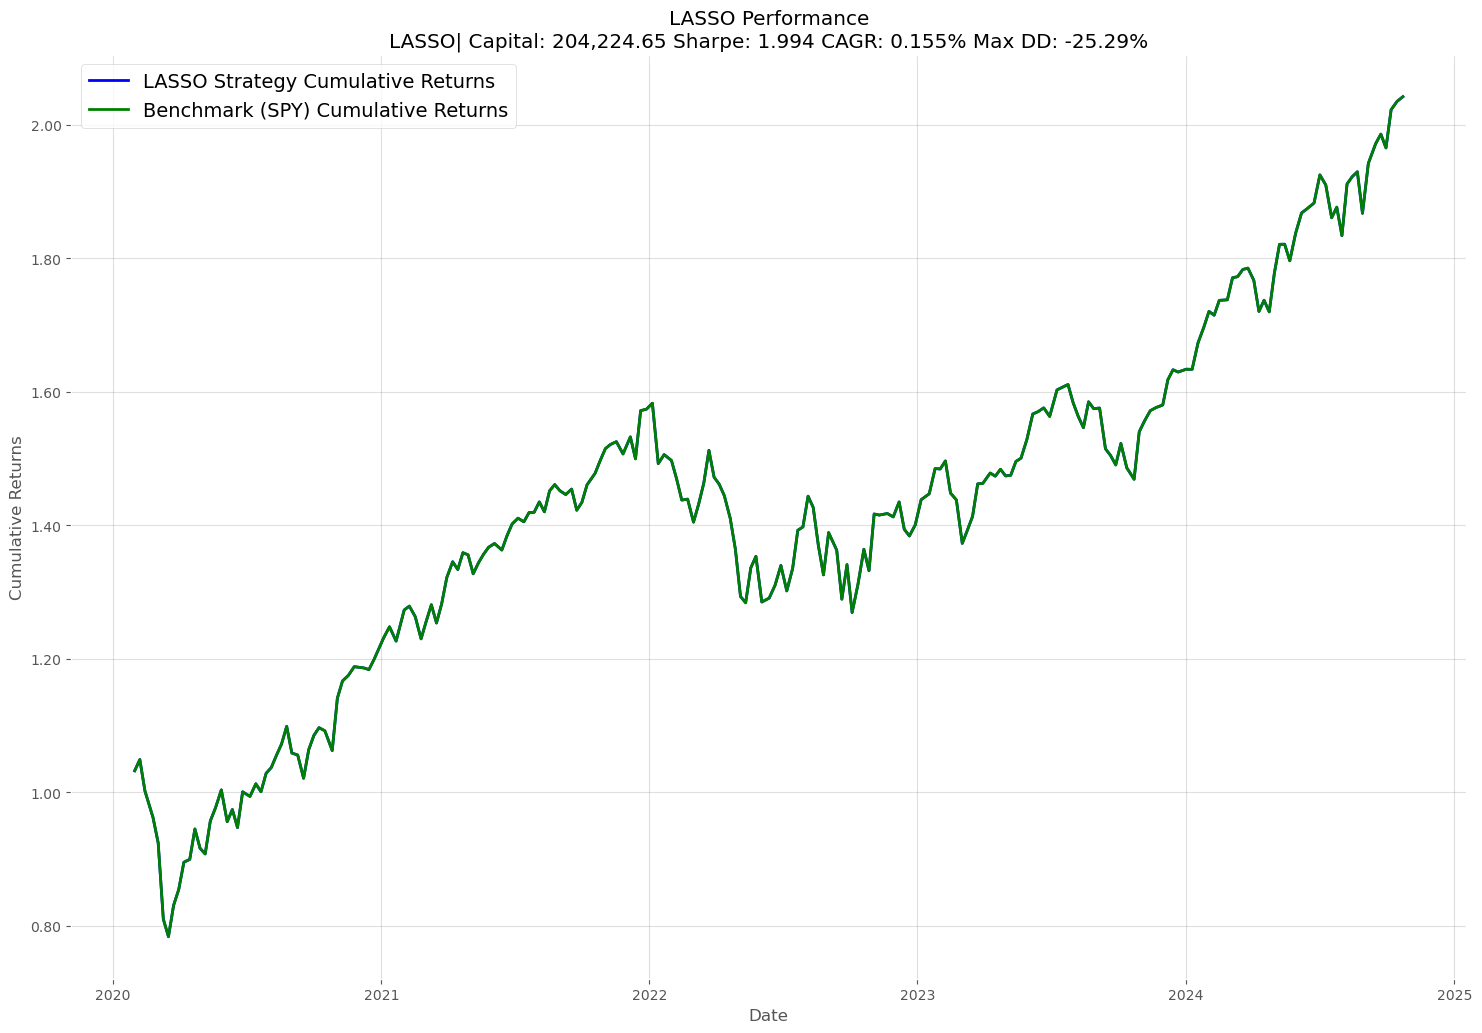

EN| Capital: 204,224.65 Sharpe: 1.994 CAGR: 0.155% Max DD: -25.29%


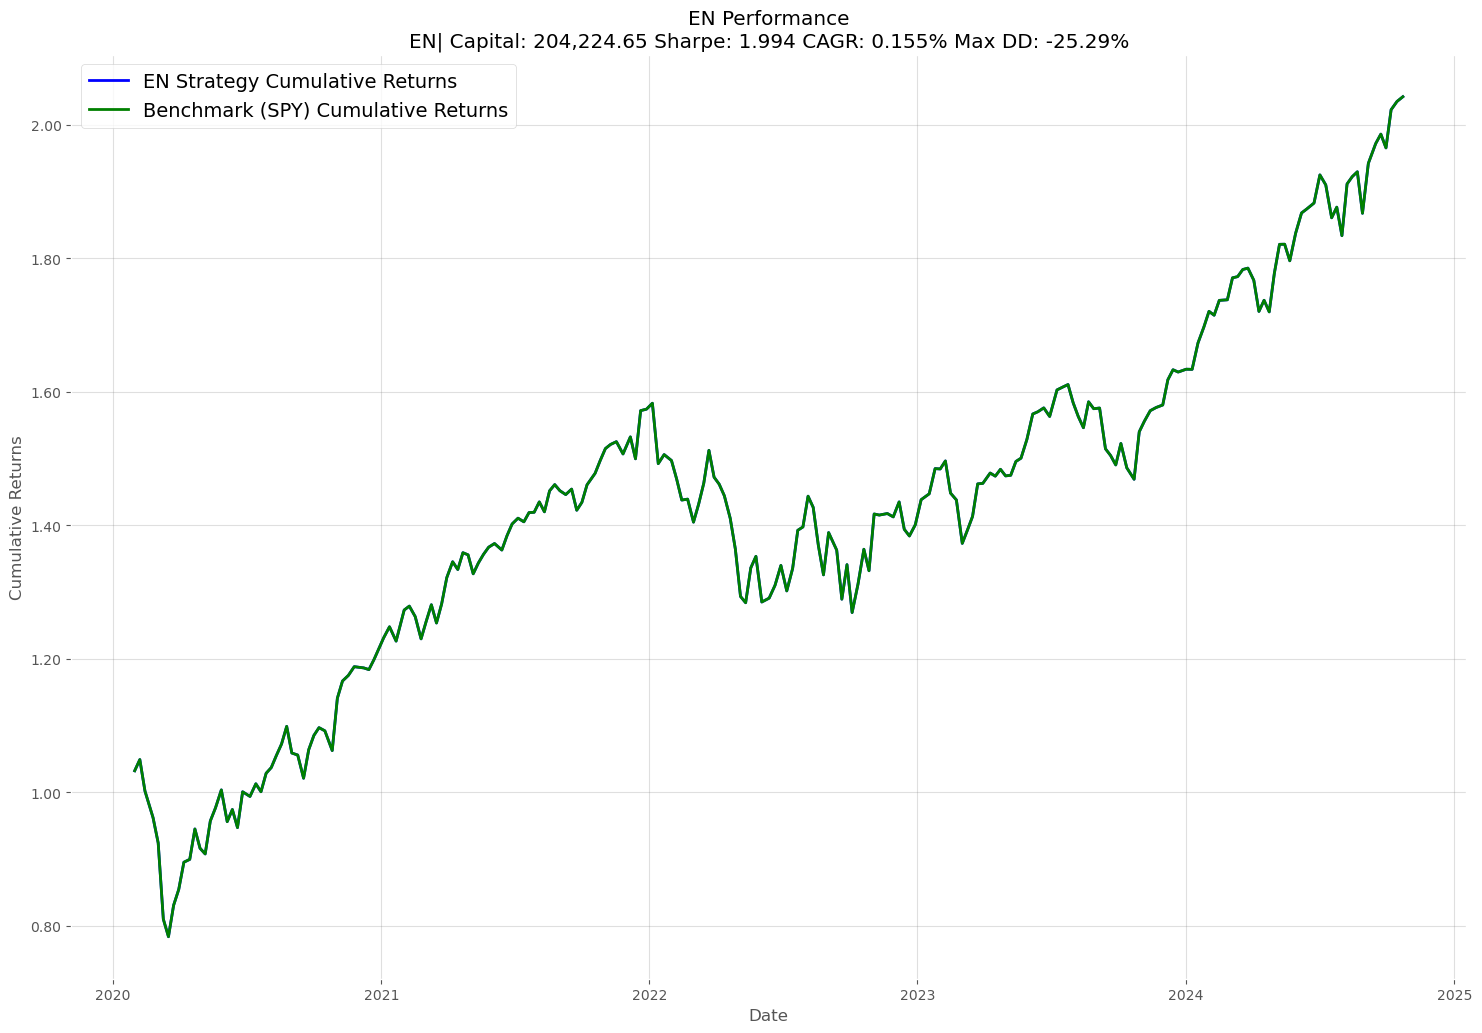

CART| Capital: 70,119.35 Sharpe: -0.985 CAGR: -0.066% Max DD: -42.17%


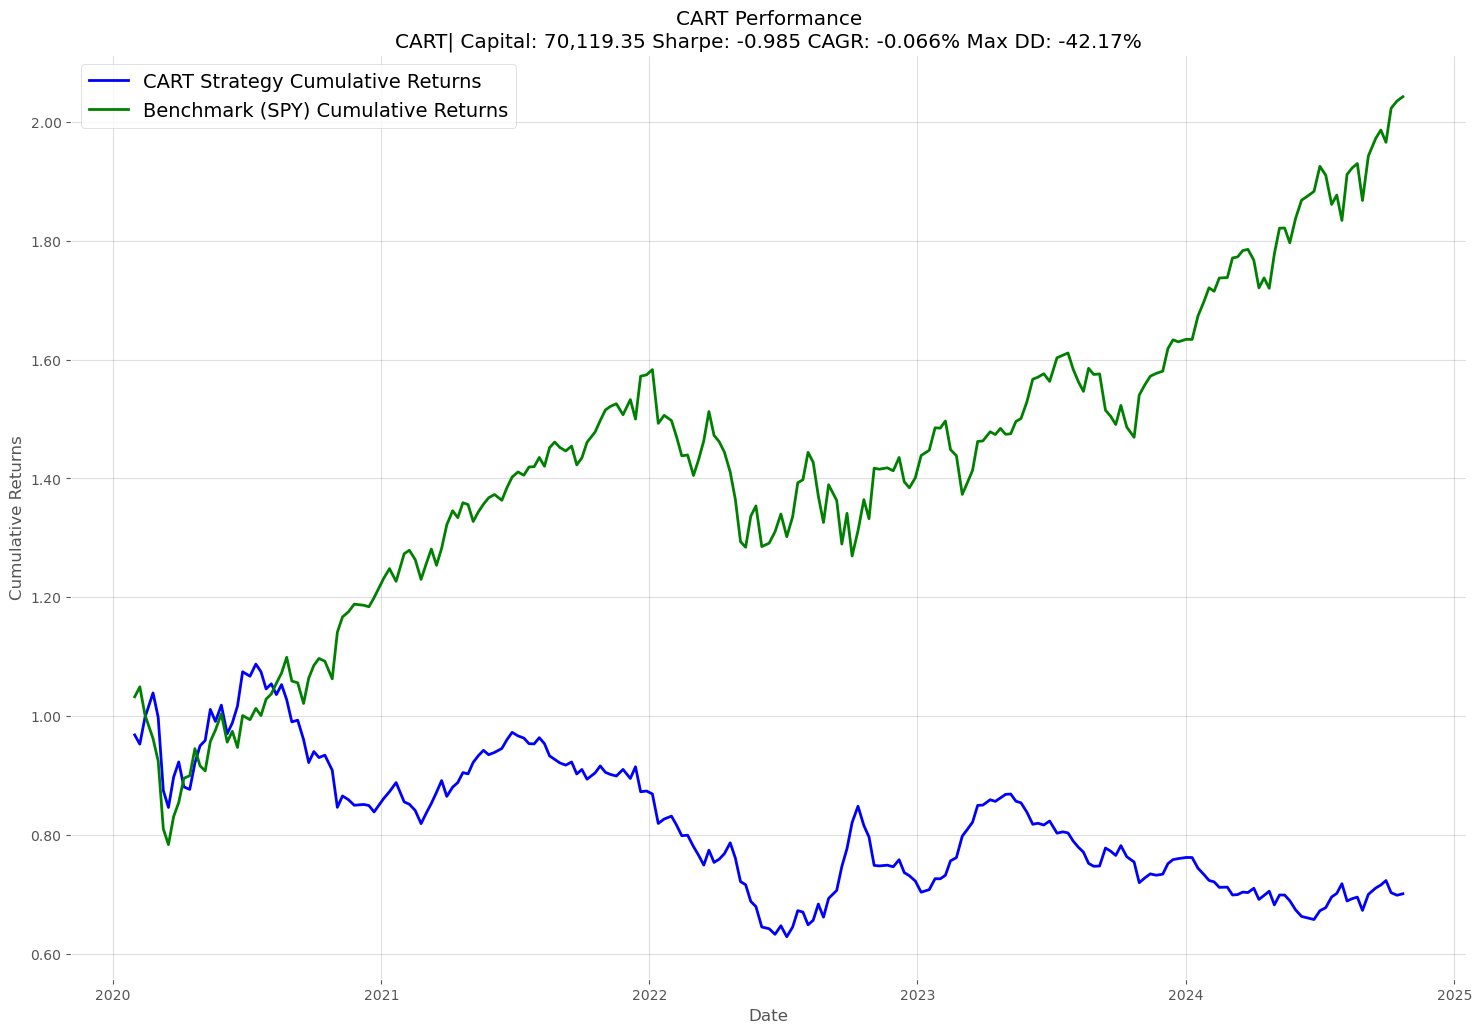

KNN| Capital: 139,462.96 Sharpe: 0.923 CAGR: 0.080% Max DD: -27.67%


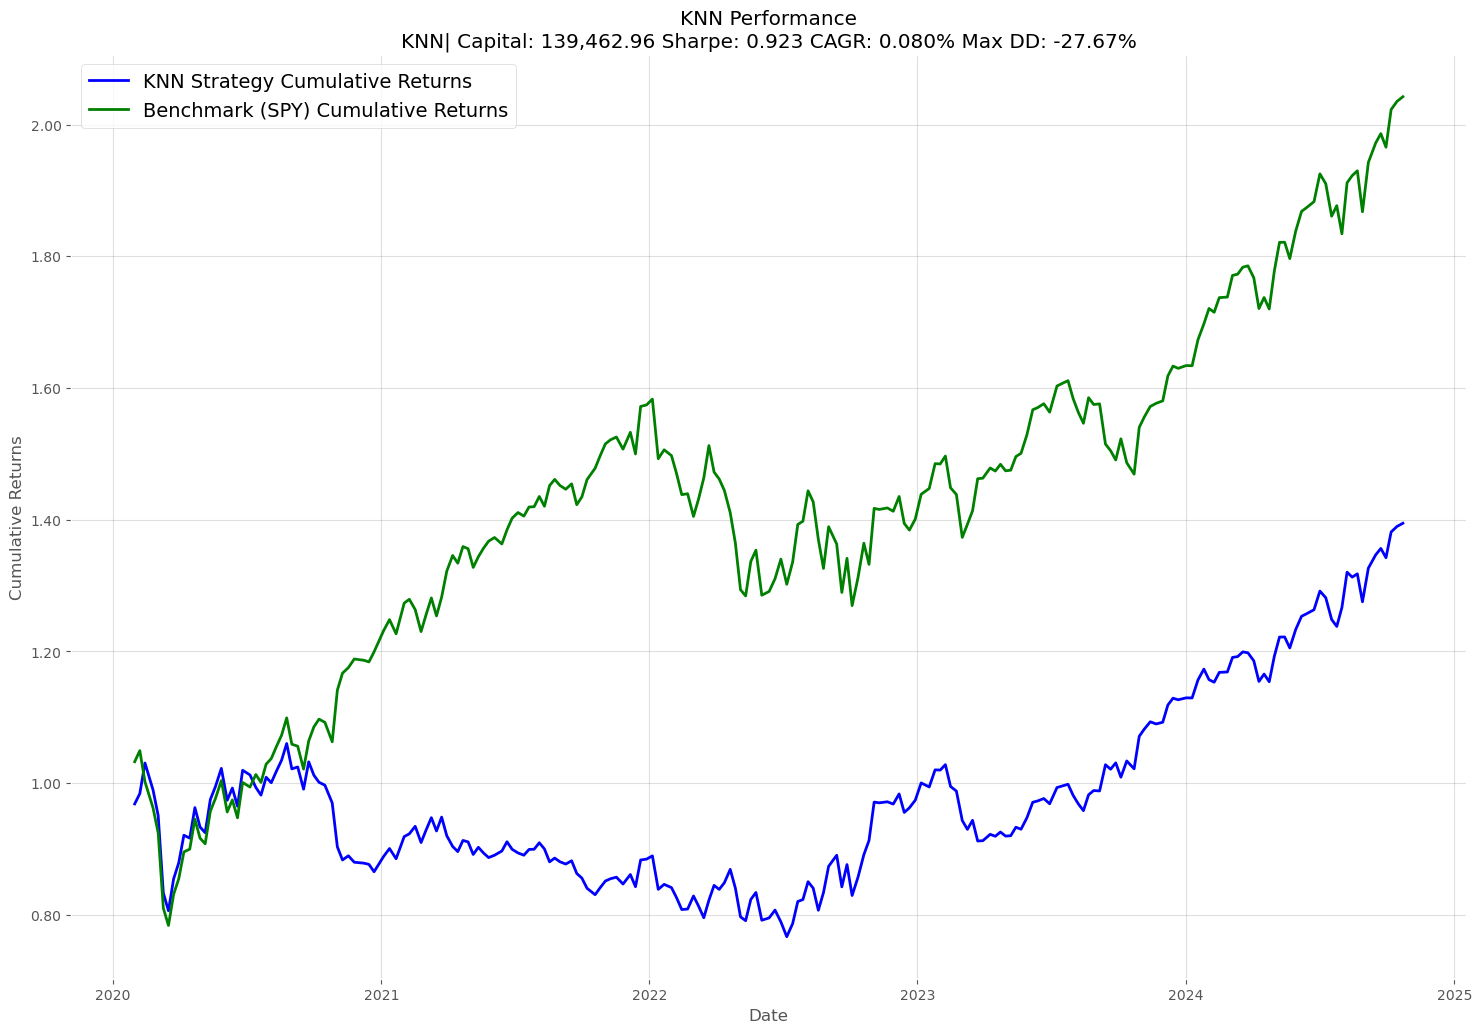

SVR| Capital: 207,713.25 Sharpe: 2.042 CAGR: 0.159% Max DD: -19.51%


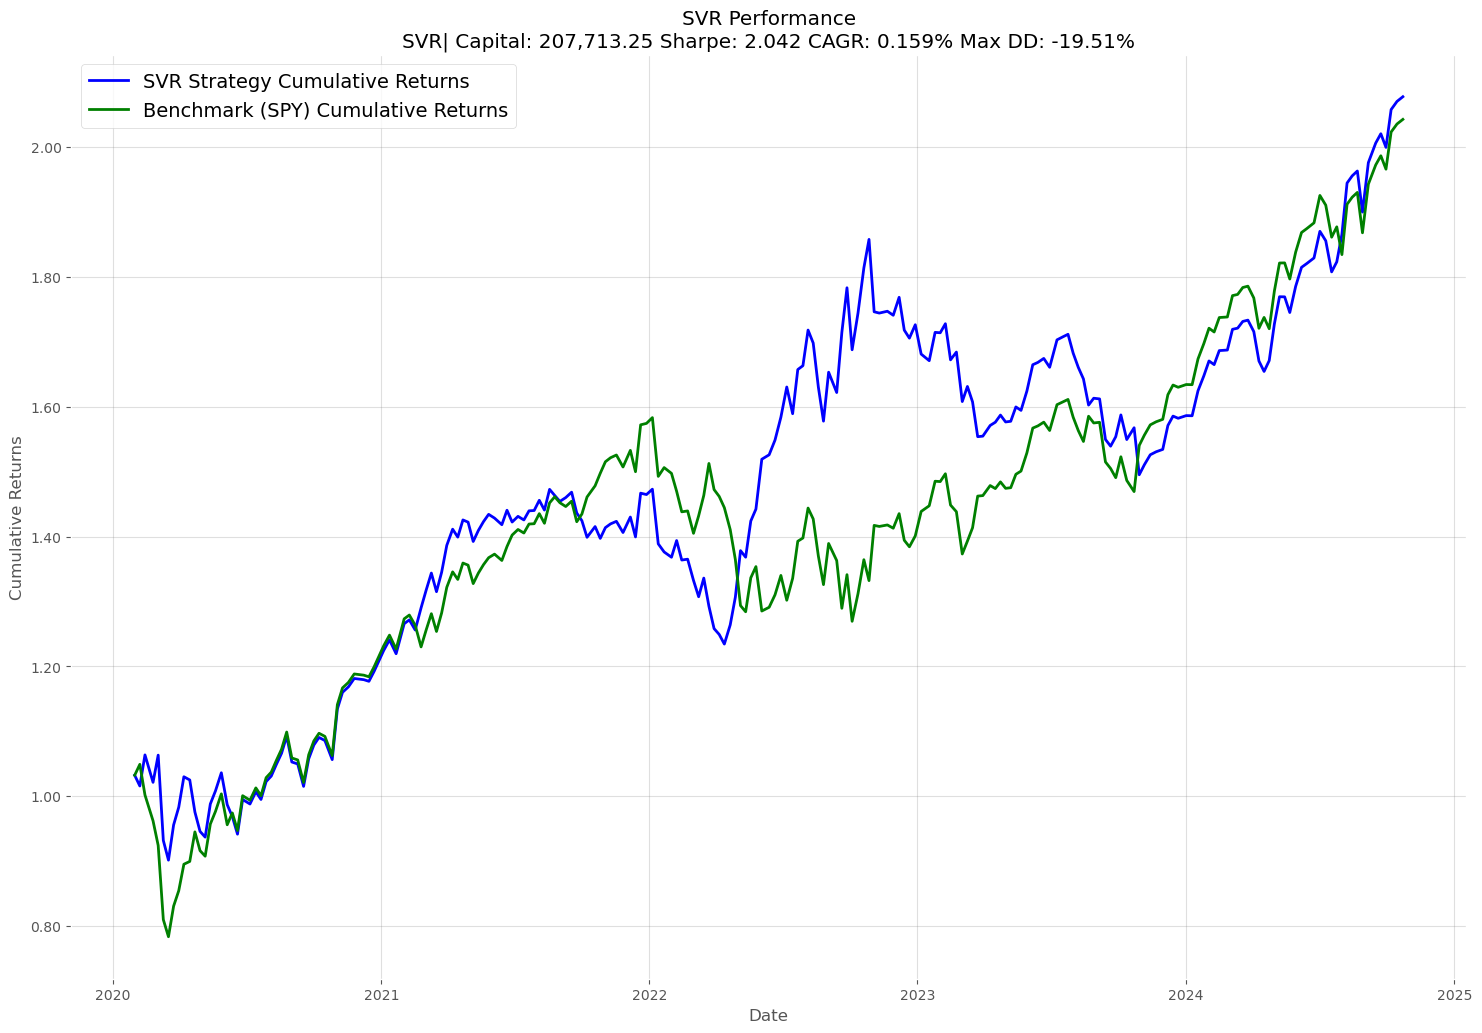

RFR| Capital: 133,564.17 Sharpe: 0.803 CAGR: 0.070% Max DD: -28.26%


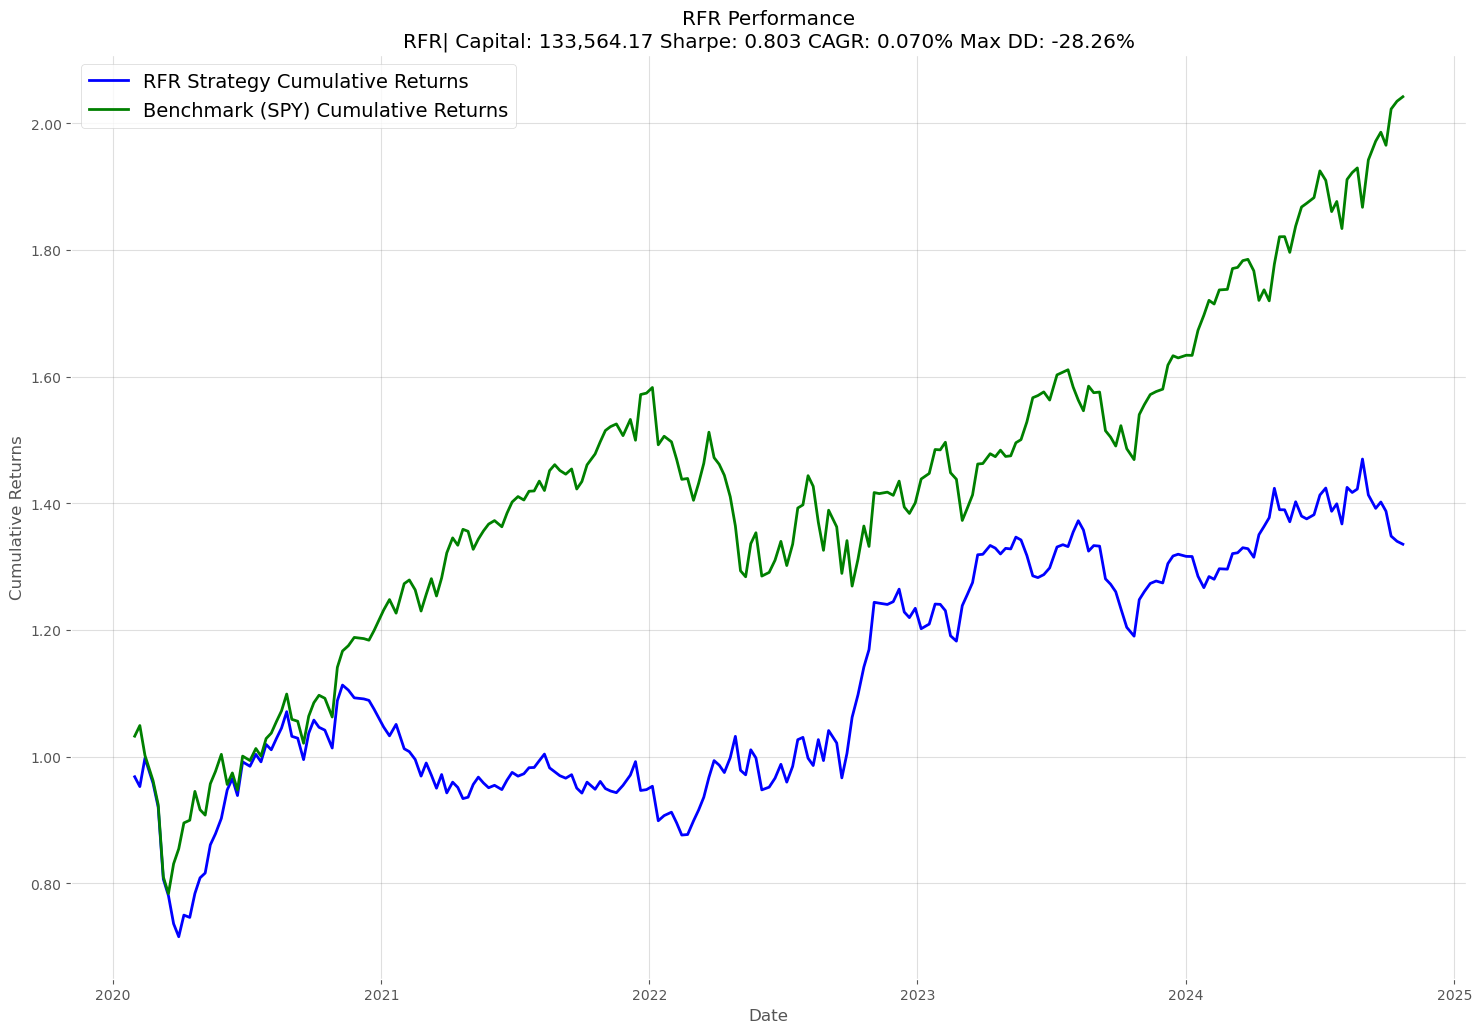

ETR| Capital: 136,390.76 Sharpe: 0.861 CAGR: 0.075% Max DD: -21.77%


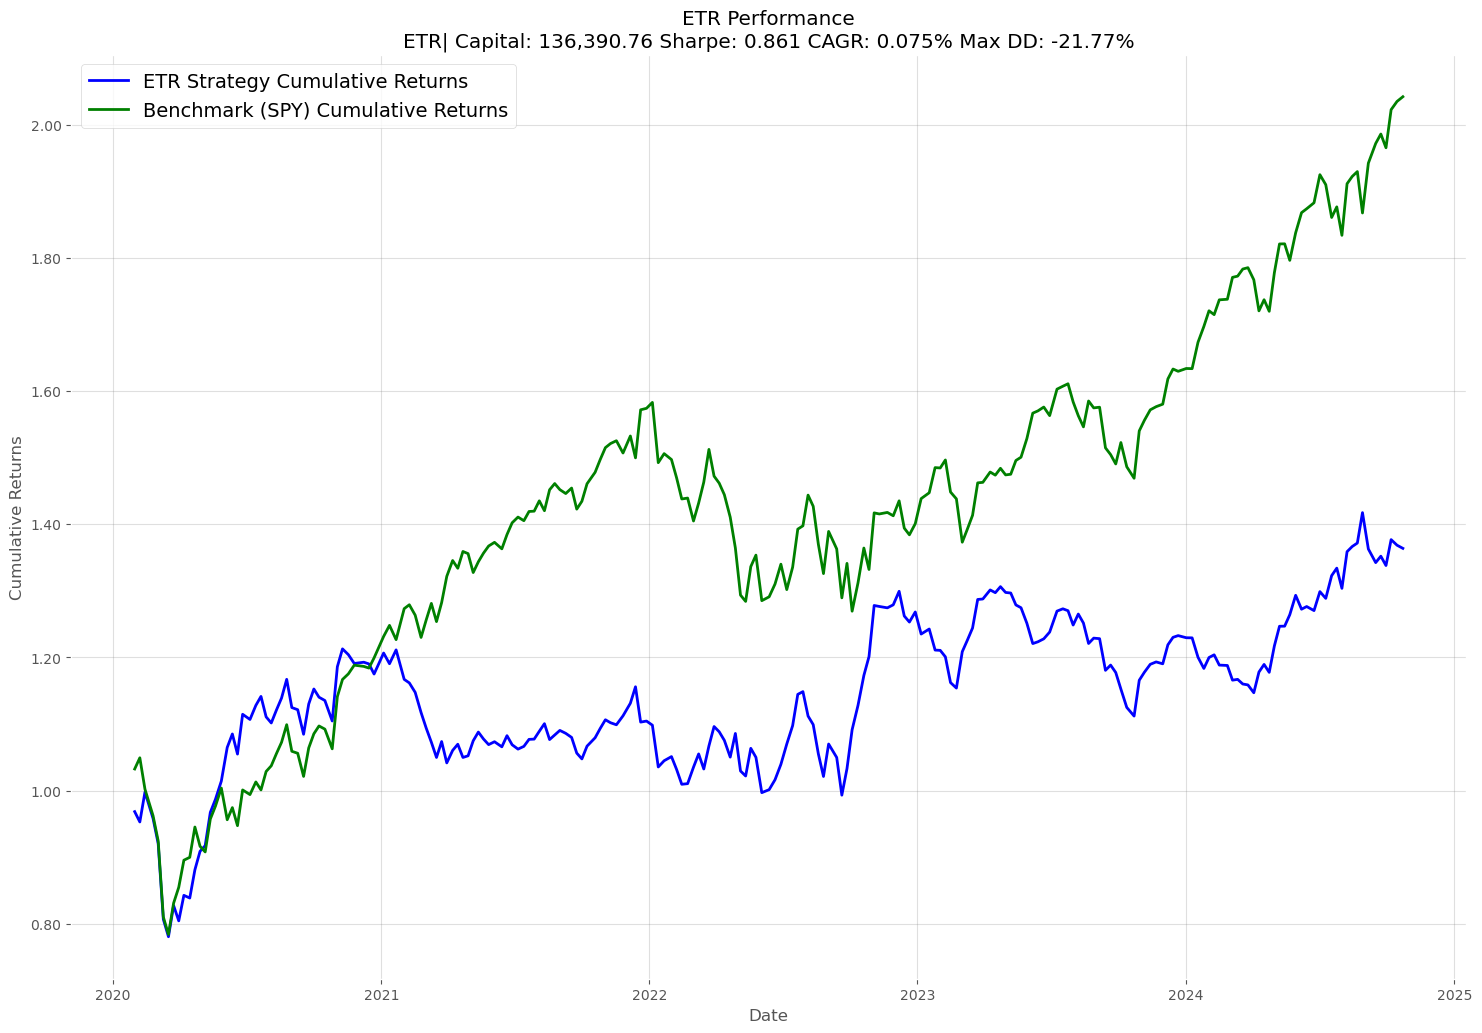

GBR| Capital: 116,935.97 Sharpe: 0.434 CAGR: 0.041% Max DD: -25.29%


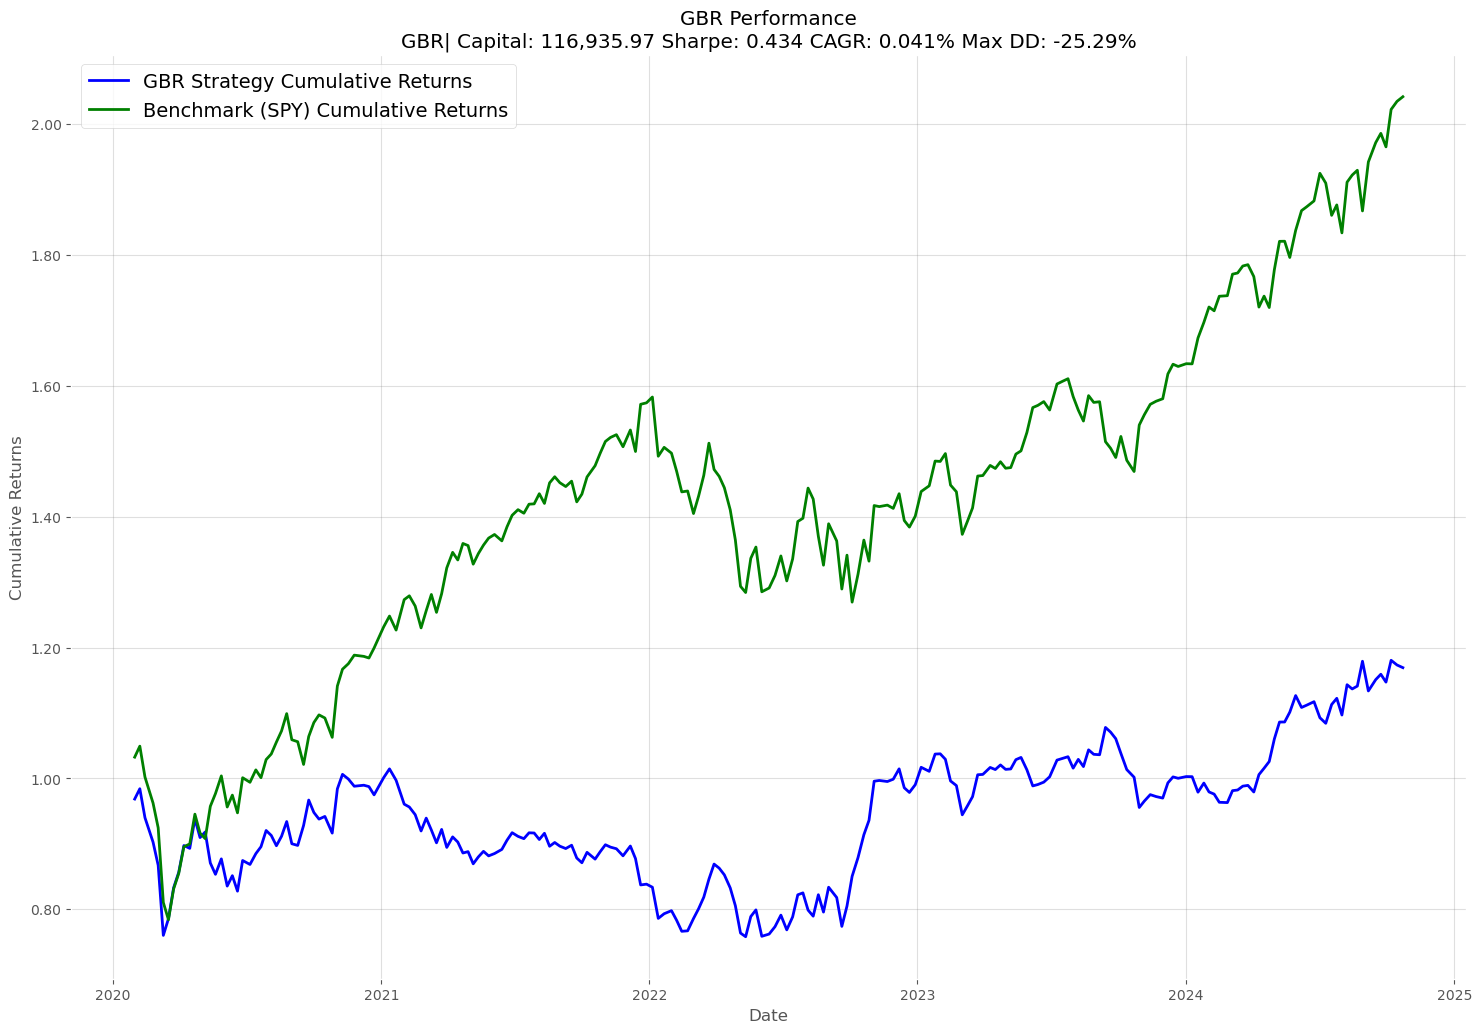

ABR| Capital: 64,916.37 Sharpe: -1.200 CAGR: -0.081% Max DD: -50.24%


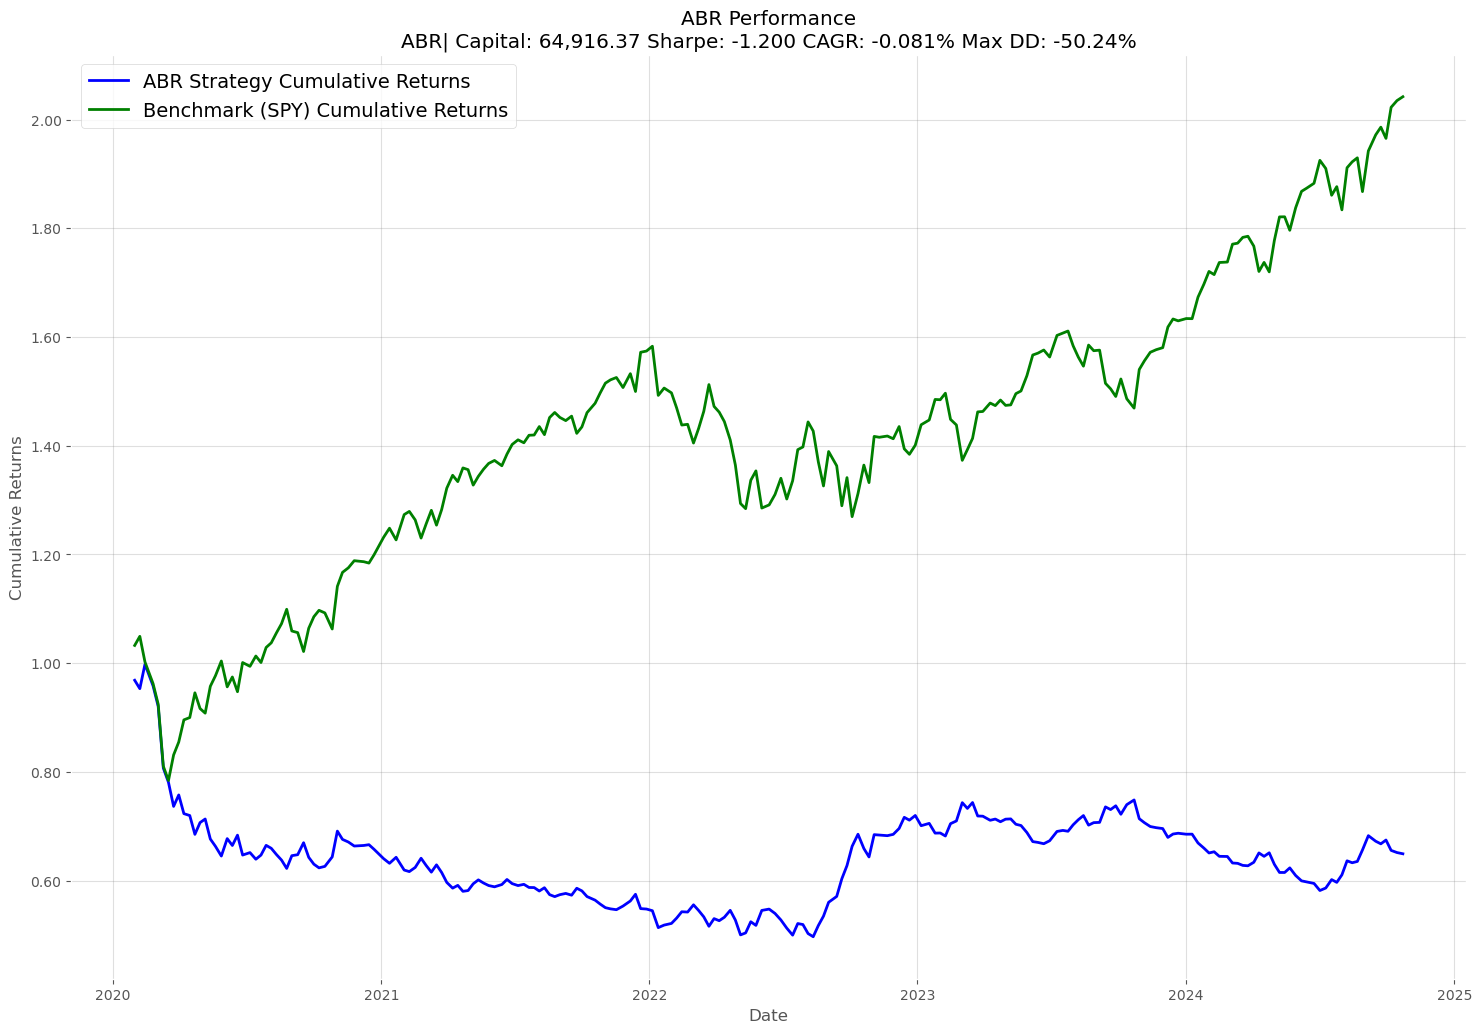

ARIMA| Capital: 99,717.55 Sharpe: -0.008 CAGR: 0.006% Max DD: -34.88%


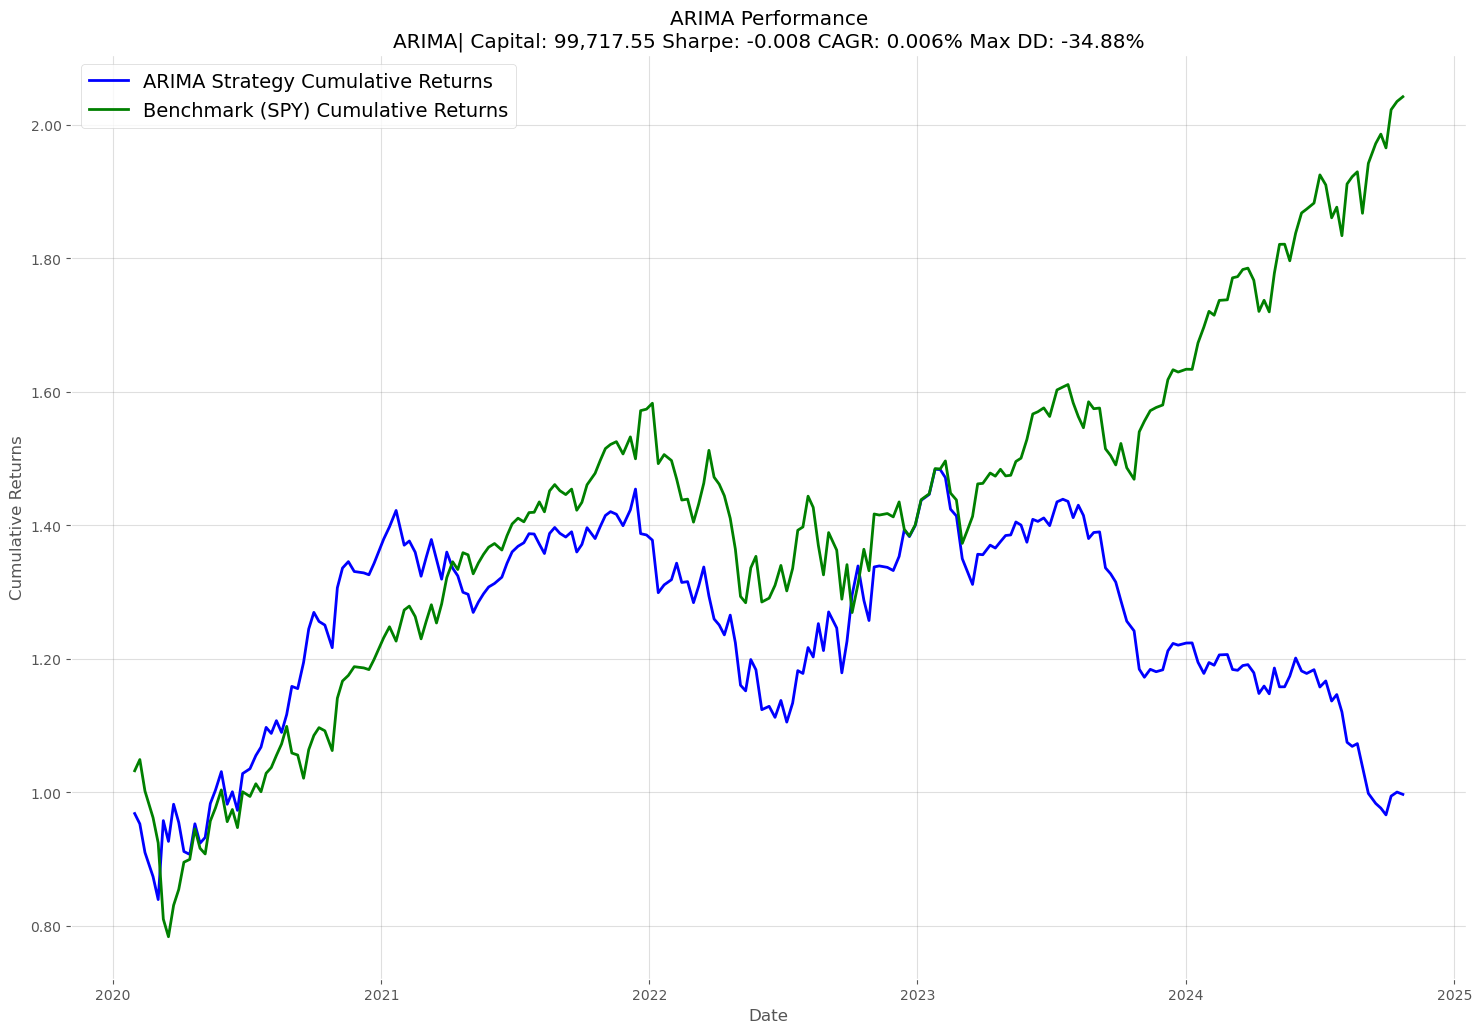

In [70]:
test_df1 = test_df.copy()
initial_capital = 1e5

for name in test_df1.columns:
    
    position = f"{name}_position"
    strategy = f"{name}_strategy"
    capital = f"{name}_capital"
    cumulative = f"{name}_cumulative"
    performance = f"{name}_performance"
    drawdown = f"{name}_drawdown"
    sharpe = f"{name}_sharpe"
    cagr = f"{name}_cagr"
    
    #Strategy Returns
    test_df1[position] = 0
    test_df1[position] = np.sign(test_df1[name])
    
    test_df1[strategy] = 0
    test_df1[strategy] = spy_log['spy_predictions'] * test_df1[position]
    
    #Sharpe
    sharpe = np.sqrt(253) * (test_df1[strategy].mean()/test_df1[strategy].std())
    
    #Capital
    test_df1[capital] = initial_capital
    for i in range(len(test_df1)):
        test_df1[capital][i] = \
        test_df1[capital][i-1] * (test_df1[strategy].apply(np.exp)[i])
    
    #CAGR
    days = (test_df1.index[-1] - test_df1.index[0]).days
    cagr = ((((test_df1[capital][-1]) / (test_df1[capital][0]))**(365.0/days))- 1)
    
    
    #Maximum drawdown
    window = 253
    rolling_max = test_df1[capital].rolling(window = window, min_periods = 1).max()
    daily_drawdown = test_df1[capital] / rolling_max - 1.0
    max_daily_drawdown = daily_drawdown.rolling(window = window, min_periods = 1).min()
    
   
    # Calculate cumulative returns
    test_df1[cumulative] = test_df1[capital] / initial_capital

    # Compile metrics for display in the title
    metrics = f"{name}| Capital: {test_df1[capital].iloc[-1]:,.2f} Sharpe: {sharpe:.3f} CAGR: {cagr:.3f}% Max DD: {max_daily_drawdown.min()*100:.2f}%"

    # Output metrics to console
    print(metrics)

    # Create a new figure for plotting
    plt.figure(figsize=(18, 12))

    # Set the title of the plot
    plt.title(f"{name} Performance\n{metrics}")

    # Plot the cumulative returns of the strategy
    plt.plot(test_df1.index, test_df1[cumulative], label=f"{name} Strategy Cumulative Returns", color='blue', linewidth=2)

    # Plot the benchmark or comparative index (assuming SPY_log['SPY_pred'] holds prediction data)
    plt.plot(test_df1.index, spy_log['spy_predictions'].cumsum().apply(np.exp), label='Benchmark (SPY) Cumulative Returns', color='green', linewidth=2)

    # Add a legend to help distinguish between the different lines
    plt.legend(loc='upper left')

    # Add grid lines for better readability
    plt.grid(True)

    # Format the y-axis to show better formatted numbers (e.g., with commas and rounding)
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))

    # Add labels to the x-axis and y-axis
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')

    # Display the plot
    plt.show()

# <a id = "p9"> </a> <font color = "green"> Part 3 Summary of Strategy Performance </font> [back to table of contents](#top)

## Simple Moving Average (SMA) Strategy 
The Simple Moving Average (SMA) strategy computes the rolling average price of a stock over a specified period to identify potential buy and sell signals. This strategy involves calculating both short-term and long-term moving averages to determine trading positions. A buy signal is generated when the short-term moving average crosses above the long-term moving average, while a sell signal occurs when the short-term moving average crosses below the long-term moving average.

SMA is a momentum-based strategy that assumes current trends are likely to continue. It identifies short-term average trends in relation to longer-term trend.

Parameter optimization is employed to determine the best parameters, such as the length of the short and long moving averages, that maximize the strategy's returns.

Additionally, a long-only strategy permits only long positions, where the trader profits when the price increases, with no short selling allowed. In contrast, a long-short strategy allows the trader to take both long and short positions, enabling them to profit from both rising and falling prices.

#### SMA Long Only Strategy
1. **Optimised moving average period:** Short: 30 days, Long: 178 days
2. **Performance:**
- Ending capital is $641,889.14
- Sharpe Ratio: 0.8160
- Compound Annual Growth Rate (CAGR): 10.2741%
- Maximum Drawdown: -3154.7160%
- Drawdown Duration: 497 calendar days

#### SMA Long Short Strategy
1. **Optimised moving average period:** Short: 46 days, Long: 161 days
2. **Performance:**
- Ending capital is $389,290.30
- Sharpe Ratio: 0.4677
- Compound Annual Growth Rate (CAGR): 7.4111%
- Maximum Drawdown: -4971.6115%
-Drawdown Duration: 1462 calendar days

#### Overall, the SMA long only strategy with short and long moving average periods of 30 and 178 days has higher model performance with higher ending capital and higher sharpe ratio which suggest better risk to reward ratio. The strategy also has a lower maximum drawdown and drawdown period. 

--------------------------------------------------------------------------------------------------------------

## Exponential Moving Average (EMA) Strategy 
The Exponential Moving Average (EMA) strategy works similar to the SMA strategy. However, the EMA computes a weighted rolling average of a stock's price and assigns more significance to recent prices to identify potential buy and sell signals. Similar to SMA, the EMA strategy involves short-term and long-term EMAs to determine trading positions. A buy signal is generated when the short-term EMA crosses above the long-term EMA, while a sell signal occurs when the short-term EMA crosses below the long-term EMA. 

Similarly, the EMA is a momentum-based strategy that reacts faster to price changes, making it ideal for capturing trends in volatile markets.

Parameter optimization is employed to determine the best parameters, such as the length of the short and long moving averages, that maximize the strategy's returns.

#### EMA Long Only Strategy
1. **Optimised moving average period:** Short: 29 days, Long: 62 days
2. **Performance:**
- Ending capital is $614,234.99
- Sharpe Ratio: 0.8685
- Compound Annual Growth Rate (CAGR): 10.0189%
- Maximum Drawdown: -2201.7058%
- Drawdown Duration: 786 calendar days


#### EMA Long Short Strategy
1. **Optimised moving average period:** Short: 97 days, Long: 277 days
2. **Performance:**
- Ending capital is $352,849.09
- Sharpe Ratio: 0.4404
- Compound Annual Growth Rate (CAGR): 6.8572%
- Maximum Drawdown: -3378.5543%
- Drawdown Duration: 1502 calendar days

#### Overall, the EMA long only strategy with short and long moving average periods of 29 and 62 days has higher model performance with higher ending capital and higher sharpe ratio which suggest better risk to reward ratio. The strategy also has a lower maximum drawdown and drawdown period. 

--------------------------------------------------------------------------------------------------------------

## Moving Average Covergence Divergence (MACD) Strategy 
The Moving Average Convergence Divergence (MACD) strategy uses the difference between two EMAs to identify buy and sell signals. A signal line is used to confirm these buy and sell signals. A buy signal is generated when the MACD crosses above the signal line, while a sell signal occurs when the MACD crosses below it. 

MACD is a mean reversion that identifies buy and sell signals when there is a divergence of price trends. 

Parameter optimization is employed to determine the best parameters that maximize the strategy's returns, such as the length of the short and long moving averages, and the corresponding signal days.

#### MACD Long Only Strategy
1. **Optimised EMA period:** Short: 6 days, Long: 50 days, Signal Days: 13
2. **Performance:**
- Ending capital is $345,266.68
- Sharpe Ratio: 0.6406
- Compound Annual Growth Rate (CAGR): 6.7352%
- Maximum Drawdown: -2311.3452%
- Drawdown Duration: 820 calendar days

#### MACD Long Short Strategy
1. **Optimised EMA period: Short:** 6 days, Long: 50 days, Signal Days: 13
2. **Performance:**
- Ending capital is $110,604.66
- Sharpe Ratio: 0.1245
- Compound Annual Growth Rate (CAGR): 0.5316%
- Maximum Drawdown: -3842.2914%
- Drawdown Duration: 1605 calendar days

#### Overall, the MACD long only strategy with short and long moving average periods of 6 and 50 days and signal days of 13 has higher model performance with higher ending capital and higher sharpe ratio which suggest better risk to reward ratio. The strategy also has a lower maximum drawdown and drawdown period.

--------------------------------------------------------------------------------------------------------------

## Bollinger Band Strategy 
The Bollinger Band strategy also applies moving averagae but the addition of upper and lower bounds that suggests the specific standard deviations away from the moving average. A buy signal is generated when the price touches or moves below the lower band, suggesting oversold conditions, while a sell signal occurs when the price touches or moves above the upper band, indicating overbought conditions. 

The Bollinger Band strategy is a mean-reversion strategy that assumes that prices tend will revert to the moving average. 

Parameter optimization is employed to determine the best parameters that maximize the strategy's returns, such as the moving average window, and the optimal standard deviations. 

#### Bollinger Band Long Only Strategy
1. **Optimised Moving Average period:** 12 days
2. **Optimised standard deviations:** 1.20
3. **Performance:**
- Ending capital is $348,384.86
- Sharpe Ratio: 0.6534
- Compound Annual Growth Rate (CAGR): 6.7857%
- Maximum Drawdown: -2087.6155%
- Drawdown Duration: 24 calendar days

#### Bollinger Band Long Short Strategy
1. **Optimised Moving Average period:** 11 days
2. **Optimised standard deviations: Short:** 1.40
3. **Performance:**
- Ending capital is $352,189.54
- Sharpe Ratio: 0.6557
- Compound Annual Growth Rate (CAGR): 6.8467%
- Maximum Drawdown: -2087.6155%
- Drawdown Duration: 32 calendar days

#### Overall, the Bollinger band long only strategy with moving average periods of 12 days and standard deviation of 1.20 has higher model performance with higher ending capital and higher sharpe ratio which suggest better risk to reward ratio.

--------------------------------------------------------------------------------------------------------------

## Combination Strategy (SMA-MACD Long Only Strategy)
With its higher ending capital, higher CAGR, and lower drawdown, the **SMA long-only strategy** emerges as a stronger momentum-based approach, effectively capturing sustained price trends. Similarly, the **MACD long-only strategy**, with its superior performance metrics, proves to be a robust mean-reversion strategy by identifying price corrections and reversals. 

Combining these strategies could yield significant results, where the SMA strategy serves to pinpoint entry and exit points based on trend-following principles, while the MACD validates these signals by confirming momentum shifts or reversals. This hybrid approach leverages the strengths of both momentum and mean-reversion strategies, potentially reducing false signals, improving decision-making, and enhancing overall trading performance.

Parameter optimization is employed to determine the best parameters that maximize the strategy's returns, such as the moving average windows, signal days. 

#### Combination Long Only Strategy
1. **Optimised Moving Average period for SMA:** Short: 10 days, Long: 200 days
2. **Optimised EMA period:** Short: 5 days, Long: 80 days, Signal Days: 11
3. **Performance:**
- Ending capital is $857,097.77
- Sharpe Ratio: 0.8347
- Compound Annual Growth Rate (CAGR): 11.9640%
- Maximum Drawdown: -2619.8780%
- Drawdown Duration: 672 calendar days

#### Combination Long Short Strategy
1. **Optimised Moving Average period for SMA:** Short: 10 days, Long: 200 days
2. **Optimised EMA period:** Short: 5 days, Long: 80 days, Signal Days: 11
3. **Performance:**
- Ending capital is $200,438.15
- Sharpe Ratio: 0.3311
- Compound Annual Growth Rate (CAGR): 3.7253%
- Maximum Drawdown: -2137.2509%
- Drawdown Duration: 1898 calendar days

#### Overall, the combination long only strategy has higher model performance with higher ending capital and higher sharpe ratio which suggest better risk to reward ratio. The strategy also has a lower maximum drawdown and drawdown period.

--------------------------------------------------------------------------------------------------------------

## Combination Strategy (SMA-MACD Long Only Strategy)
With its higher ending capital, higher CAGR, and lower drawdown, the **SMA long-only strategy** emerges as a stronger momentum-based approach, effectively capturing sustained price trends. Similarly, the **MACD long-only strategy**, with its superior performance metrics, proves to be a robust mean-reversion strategy by identifying price corrections and reversals. 

Combining these strategies could yield significant results, where the SMA strategy serves to pinpoint entry and exit points based on trend-following principles, while the MACD validates these signals by confirming momentum shifts or reversals. This hybrid approach leverages the strengths of both momentum and mean-reversion strategies, potentially reducing false signals, improving decision-making, and enhancing overall trading performance.

Parameter optimization is employed to determine the best parameters that maximize the strategy's returns, such as the moving average windows, signal days. 

#### Combination Long Only Strategy
1. **Optimised Moving Average period for SMA:** Short: 10 days, Long: 200 days
2. **Optimised EMA period:** Short: 5 days, Long: 80 days, Signal Days: 11
3. **Performance:**
- Ending capital is $857,097.77
- Sharpe Ratio: 0.8347
- Compound Annual Growth Rate (CAGR): 11.9640%
- Maximum Drawdown: -2619.8780%
- Drawdown Duration: 672 calendar days

#### Combination Long Short Strategy
1. **Optimised Moving Average period for SMA:** Short: 10 days, Long: 200 days
2. **Optimised EMA period:** Short: 5 days, Long: 80 days, Signal Days: 11
3. **Performance:**
- Ending capital is $200,438.15
- Sharpe Ratio: 0.3311
- Compound Annual Growth Rate (CAGR): 3.7253%
- Maximum Drawdown: -2137.2509%
- Drawdown Duration: 1898 calendar days

#### Overall, the combination long only strategy has higher model performance with higher ending capital and higher sharpe ratio which suggest better risk to reward ratio. The strategy also has a lower maximum drawdown and drawdown period.

--------------------------------------------------------------------------------------------------------------

## Machine Learning
Overall, consideratiing all the various Machine Learning algorithms, the top performing ML model is **SVR**.
Support Vector Regression (SVR) is a regression model that aims to predict variables by identifying a optimal function that will approximate the relationship between input features and target variable while keeping the predicted error low. 

**Performance:**
- Ending capital is $207,713.25
- Sharpe Ratio: 2.042
- Compound Annual Growth Rate (CAGR): 0.159%
- Maximum Drawdown: -19.51%

--------------------------------------------------------------------------------------------------------------
## Summary Table: 

| Strategy                     | Ending Capital ($) | Sharpe Ratio | CAGR (%) | Max Drawdown (%) |
|------------------------------|--------------------:|-------------:|---------:|-----------------:|
| SMA Long Only               |          641,889.14 |        0.8160 |   10.2741 |       -3154.7160 |
| SMA Long Short              |          389,290.30 |        0.4677 |    7.4111 |       -4971.6115 |
| EMA Long Only               |          614,234.99 |        0.8685 |   10.0189 |       -2201.7058 |
| EMA Long Short              |          352,849.09 |        0.4404 |    6.8572 |       -3378.5543 |
| MACD Long Only              |          345,266.68 |        0.6406 |    6.7352 |       -2311.3452 |
| MACD Long Short             |          110,604.66 |        0.1245 |    0.5316 |       -3842.2914 |
| Bollinger Band Long Only    |          348,384.86 |        0.6534 |    6.7857 |       -2087.6155 |
| Bollinger Band Long Short   |          352,189.54 |        0.6557 |    6.8467 |       -2087.6155 |
| Combination Long Only       |          857,097.77 |        0.8347 |   11.9640 |       -2619.8780 |
| Combination Long Short      |          200,438.15 |        0.3311 |    3.7253 |       -2137.2509 |
| SVR                         |          207,713.25 |        2.0420 |    0.1590 |         -19.5100 |

## Top 3 Strategies
1. **Strategy 1: Combination Long Only Strategy**
- Ending Capital: $857,097.77 (highest)
- Sharpe Ratio: 0.8347 (high)
- CAGR: 11.9640% (highest)
- Maximum Drawdown: -2619.8780%
Commentry: As mentioned, with the hybrid model, it might be better optimise to capture short and long term trends which might yield higher strategy returns. 

2. **Strategy 2: SMA Long Only Strategy**
- Ending Capital: $641,889.14
- Sharpe Ratio: 0.8160
- CAGR: 10.2741%
- Maximum Drawdown: -3154.7160%
Commentry: Although the relatively high returns, the draw down is slightly higher than most of the other strategies

3. **Strategy 3: EMA Long Only Strategy**
- Ending Capital: $614,234.99
- Sharpe Ratio: 0.8685 (highest Sharpe ratio)
- CAGR: 10.0189%
- Maximum Drawdown: -2201.7058% (lowest among top strategies)
Commentry: The strategy has the hight sharpe ratio and the lowest maximum drawdown amongst the top 3 strategy. 

# <a id = "p10"> </a> <font color = "green"> Part 4 Self-Critique </font>  [back to table of contents](#top)

## Simple Moving Average (SMA) Strategy 
Overall the strategy was able to generate relatively high returns and reasonably high sharpe ratio, which suggest strong risk-adjusted returns. Notably,the maximum drawdown is high. However, the strategy looks at historical trend, the lagging indicator might not be a good proxy for future returns. Additionally with such a drastic different time period between the short and long moving average period, the strategy might not be able to fully capture market movements in volatile market condition. 

## Exponential Moving Average (EMA) Strategy 
Overall the strategy was able to one of the highest returns and reasonably high sharpe ratio, which also suggest strong risk-adjusted returns. However, due to the nature of EMA, the strategy places a greater emphasis on recent price action whichm ight cause overreaction to short-term volatility, leading to false signal. Similar to SMA, the EMA is a lagging indciator which might not be a good proxy for future returns. Continuous performance evaluation will be required to ensure the model parameter remains relevant. 

## MACD Strategy 
As MACD uses the basis of EMA to generate its entry and exit points, it is also a lagging indicator. 

## Bollinger band Strategy 
The bollingerband strategy relies on the assumption that prices will revert to its mean, which might fail during prolong market trends or structural market changes. Additionallty, the standard deviations might not be able to handle suddenly volailtiy spikes. 

## Combination Strategy 
The strategy also uses historical data to generate its entry and exit points, as such, it is also a lagging indicator. 

## Machine Learning Model 
Machine learning models can struggle to generalise the data under unseen market condition, such as market regime changes. 

## Overall Critiques
- More hybrid models can be identified to future enhance the strategies. Hybrid strategies might be better equipped to handle volatile data or generate higher returns. 
- Noticably, most of the strategies have significantly high maximum drawdowns. As such, it would be ideal to minimise these drawdowns. 
- Rather than 80:20 window period, rolling window training and testing of the model might offer more robust models. 
- More parameter tuning could help futher enhance the strategy's performance. However, it should be noted that this can also lead to overfitting issues. 
- Continous model mointoring will be required to ensure the strategies ability to produce consistent results/returns. 

## <a id = "p10"> </a> <font color = "green"> Part 5 Contribution Statement </font>  [back to table of contents](#top)

#### Everyone contributed equally